In [30]:
import pandas as pd
import numpy as np
import itertools as it
import functools as ft
import multiprocessing as mp
from time import time
from collections import OrderedDict
import sys
import tqdm

from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model.coordinate_descent import LinearModelCV
from sklearn.linear_model import ElasticNetCV
from sklearn.base import RegressorMixin
from sklearn.linear_model.base import LinearModel
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.base import BaseEstimator
from sklearn.metrics import *

from scipy.stats import norm
from scipy.stats.mstats import gmean
from collections import Counter


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
agg_data = pd.read_csv('../data/agg_growth.csv', index_col=0)
agg_data.head()

,Drug,Concentration,Target,Growth,AAK1,ABL1,ABL2,ACVR1,ACVR1B,ACVR2B,...,uacc812,uacc893,umc11,umuc3,vmrclcd,wm115,wm2664,yapc,zr751,zr75b
53257,silmitasertib,3.00,-0.426184,-0.330026,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
42989,osi027,0.03,2.489425,0.987205,0.0,0.000000,0.000000,0.0,0.076540,0.0,...,0,0,0,0,0,0,0,0,0,0
36715,mgcd265,0.30,3.085930,0.997971,0.0,-0.367669,-0.212716,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
35826,masitinib,1.00,0.895365,0.629408,0.0,-0.478263,-0.317027,0.0,0.000000,0.0,...,0,0,0,0,0,0,0,0,0,0
43312,osi027,30.00,-0.056795,-0.045292,0.0,0.000000,0.000000,0.0,-9.642757,0.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# filter out the less common drugs
drugs = agg_data.Drug
c = Counter(drugs)
filtered_drug_list = [x for x,y in c.most_common() if y > 50]
drug_filter = drugs.isin(filtered_drug_list)
drugs = drugs[drug_filter]
agg_data = agg_data[drug_filter]

conc = agg_data.Concentration

# targ = agg_data.Target # deprecated
y = agg_data.Growth
new_y = np.arctanh(y) # throws a warning as inf occurs
new_y[y == 1] = np.arctanh(1 - 1e-12) # replace inf with large number

X = agg_data[agg_data.columns[4:]]

print(X.shape)

(61824, 662)


/opt/anaconda/envs/shared_py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in arctanh
  del sys.path[0]
/opt/anaconda/envs/shared_py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in arctanh
  del sys.path[0]


In [68]:
class regDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
        
    def __len__(self):
        return self.y.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

class torchMLPRegressor(BaseEstimator):
    def __init__(self, in_dims=662, hidden_size=100, number_hidden=3, hidden_activation=nn.Tanh(), minibatch=32, dropout=0.1, num_workers=2, max_epochs=30, tol=1e-2, output_activation = nn.Tanh(), out_dims=1, weight_decay=1e-4, criterion=nn.MSELoss()):
        self.in_dims = in_dims
        self.hidden_size = hidden_size
        self.out_dims=out_dims
        self.train_dataset = None
        self.test_dataset = None
        self.hidden_activation = hidden_activation
        self.criterion = criterion
        self.output_activation = output_activation
        self.dropout = dropout
        self.tol = tol
        self.max_epochs = max_epochs
        self.minibatch = minibatch
        self.num_workers = num_workers
        self.number_hidden = number_hidden
        
        layers_dict = OrderedDict()
        layers_dict['input'] = nn.Linear(self.in_dims, self.hidden_size)
        for i in range(self.number_hidden):
            layers_dict['hidden_'+str(i)] = nn.Linear(self.hidden_size, self.hidden_size)
            
            if dropout > 0:
                layers_dict['dropout_'+str(i)] = nn.Dropout(self.dropout)
                
            layers_dict['activation_'+str(i)] = self.hidden_activation
            
        layers_dict['output'] = nn.Linear(self.hidden_size, self.out_dims)

        self.model = nn.Sequential(layers_dict)
        self.weight_decay = weight_decay
        self.optimizer = optim.Adam(self.model.parameters(), weight_decay=self.weight_decay)
        
    def fit(self, X, y, verbose=False):
        self.train_dataset = regDataset(X, y)
        self.model = self.model.cuda()
        self.model.train()
        
        dataloader = DataLoader(self.train_dataset, batch_size=self.minibatch, num_workers=self.num_workers, shuffle=True)
        delta = 1
        last_loss = torch.Tensor([float('inf')])
        epoch_loss = torch.Tensor([0])
        
        
        for epoch in range(self.max_epochs):
            if delta < self.tol:
                print('Complete! Reached tolerance')
                break
                        
            epoch_loss = torch.Tensor([0])
            
            with tqdm.tqdm(total = self.train_dataset.__len__(), desc='Epoch '+str(epoch)+': ', leave=True, ncols=80) as pbar:
                for covariates, response in iter(dataloader):

                    self.optimizer.zero_grad()

                    covariates = covariates.cuda()
                    response = response.cuda()

                    preds = self.output_activation(self.model(covariates))

                    loss = self.criterion(torch.squeeze(preds), torch.squeeze(response))
                    #print(loss)
                    epoch_loss += loss

                    loss.backward()
                    self.optimizer.step()

                    pbar.update(self.minibatch)
            
            del pbar
            

            epoch_loss /= (self.train_dataset.__len__() / self.minibatch)
            delta = (last_loss - epoch_loss)[0]
            last_loss = epoch_loss 
            
            sys.stdout.flush()

            if verbose:  
                print('Average minibatch loss: ' + str(np.round(epoch_loss[0].detach().numpy(),5)))
                print('---------------')
            
            
                
        
        self.model = self.model.cpu()
        self.model.eval()
        
    def predict(self, X, cpu=True):
        X = torch.Tensor(X)
        
        if cpu:
            return self.model(X)
        else:
            X = X.cuda()
            self.model = self.model.cuda()
            
            preds = self.output_activation(model(X))
            preds = preds.cpu()
            X = X.cpu()
            self.model = self.model.cpu()
            
            return preds
            
        
    
    def score(self, X, y, cpu=True):
        X = torch.Tensor(X)
        y = torch.Tensor(y)

        if cpu:
            preds = self.output_activation(self.model(X))
            return self.criterion(torch.squeeze(preds), torch.squeeze(y))
        else:
            self.model = self.model.cuda()
            X = X.cuda()
            preds = self.output_activation(self.model(X))
            preds = preds.cpu()
            X = X.cpu()
            self.model = self.model.cpu()
            
            return self.criterion(torch.squeeze(preds), torch.squeeze(y))
        
    def set_params(self, **params):
        BaseEstimator.set_params(self, **params)
        return
    
    def get_params(self, deep=True, **kwargs):
        params = BaseEstimator.get_params(self, deep=deep, **kwargs)
        return params
            

In [69]:
from sklearn.base import clone

In [70]:
model = torchMLPRegressor(dropout=0.2)

In [71]:
model.get_params()

{'criterion': MSELoss(),
 'dropout': 0.2,
 'hidden_activation': Tanh(),
 'hidden_size': 100,
 'in_dims': 662,
 'max_epochs': 30,
 'minibatch': 32,
 'num_workers': 2,
 'number_hidden': 3,
 'out_dims': 1,
 'output_activation': Tanh(),
 'tol': 0.01,
 'weight_decay': 0.0001}

In [72]:
# this needs to work for GridSearch
clone(model)

torchMLPRegressor(criterion=MSELoss(), dropout=0.2, hidden_activation=Tanh(),
         hidden_size=100, in_dims=662, max_epochs=30, minibatch=32,
         num_workers=2, number_hidden=3, out_dims=1,
         output_activation=Tanh(), tol=0.01, weight_decay=0.0001)

In [73]:
model.fit(X.values, y.values, verbose=True)

Epoch 1:   0%|                                        | 0/61824 [00:00<?, ?it/s]

Average minibatch loss: 0.15047
---------------


Epoch 2:   0%|                                        | 0/61824 [00:00<?, ?it/s]

Average minibatch loss: 0.12208
---------------


Epoch 2: 100%|██████████████████████████| 61824/61824 [00:10<00:00, 5936.57it/s]


Average minibatch loss: 0.11587
---------------
Complete! Reached tolerance


In [34]:
model.score(X.values, y.values)

tensor(0.1111, grad_fn=<MseLossBackward>)

In [76]:
logo = LeaveOneGroupOut()

param_grid = {
    'dropout': [0.1, 0.2, 0.3],
    'tol': [1e-2, 3e-3, 1e-3],
    'number_hidden': [2,3],
    'in_dims': [662],
    'hidden_size': [100],
    'hidden_activation': [nn.Tanh()],
    'minibatch': [32],
    'dropout': [0.1],
    'num_workers': [2],
    'max_epochs': [30],
    'output_activation': [nn.Tanh()],
    'out_dims': [1],
    'weight_decay': [1e-4],
    'criterion': [nn.MSELoss()]
}

search = GridSearchCV(torchMLPRegressor(),
                     cv=logo.split(X.values, y.values, groups=drugs),
                     param_grid=param_grid,
                     n_jobs=None,
                     iid=False,
                     refit=False,
                     return_train_score=True,
                     verbose=True)

In [77]:
search.fit(X.values, y.values)

Fitting 68 folds for each of 6 candidates, totalling 408 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Epoch 0: : 60480it [00:10, 5737.79it/s]                                         
Epoch 1: : 60480it [00:10, 5976.11it/s]                                         
Epoch 2: : 60480it [00:10, 5659.49it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:10, 5954.86it/s]                                         
Epoch 1: : 61056it [00:10, 5840.49it/s]                                         
Epoch 2: : 61056it [00:09, 6123.65it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6254.24it/s]                                         
Epoch 1: : 61184it [00:10, 6636.21it/s]                                         
Epoch 2: : 61184it [00:10, 5692.01it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60864/60864 [00:10<00:00, 5769.21it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 5866.09it/s]                                         
Epoch 1: : 61216it [00:11, 5268.25it/s]                                         
Epoch 2: : 61216it [00:10, 6039.72it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60928/60928 [00:08<00:00, 6984.59it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:11, 5475.48it/s]                                         
Epoch 1: : 60640it [00:10, 5691.15it/s]                                         
Epoch 2: : 60640it [00:10, 5830.62it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:10, 5744.65it/s]                                         
Epoch 1: : 61120it [00:11, 5505.81it/s]                                         
Epoch 2: : 61120it [00:10, 5793.36it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:11, 5517.93it/s]                                         
Epoch 1: : 60960it [00:10, 6028.77it/s]                                         
Epoch 2: : 60960it [00:10, 5687.10it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:11, 5521.54it/s]                                         
Epoch 1: : 60800it [00:10, 5602.05it/s]                                         
Epoch 2: : 60800it [00:09, 6114.06it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60448/60448 [00:09<00:00, 6495.89it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60992/60992 [00:09<00:00, 6168.39it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61184/61184 [00:09<00:00, 6124.75it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 5710.99it/s]                                         
Epoch 1: : 60960it [00:10, 5908.87it/s]                                         
Epoch 2: : 60960it [00:11, 5472.75it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:10, 5839.05it/s]                                         
Epoch 1: : 61376it [00:09, 6556.99it/s]                                         
Epoch 2: : 61376it [00:10, 5926.36it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 6100.56it/s]                                         
Epoch 1: : 61216it [00:09, 6206.93it/s]                                         
Epoch 2: : 61216it [00:08, 6969.81it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:08, 7106.60it/s]                                         
Epoch 1: : 59456it [00:10, 5684.35it/s]                                         
Epoch 2: : 59456it [00:09, 6546.79it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6152.03it/s]                                         
Epoch 1: : 61472it [00:10, 5889.15it/s]                                         
Epoch 2: : 61472it [00:10, 5713.40it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5777.34it/s]                                         
Epoch 1: : 60640it [00:11, 5349.44it/s]                                         
Epoch 2: : 60640it [00:10, 5648.20it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:08, 7215.77it/s]                                         
Epoch 1: : 61280it [00:10, 5842.50it/s]                                         
Epoch 2: : 61280it [00:09, 6314.40it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:08, 7219.98it/s]                                         
Epoch 1: : 59168it [00:09, 5928.29it/s]                                         
Epoch 2: : 59168it [00:10, 5829.14it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60704/60704 [00:10<00:00, 5629.79it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60480/60480 [00:10<00:00, 5864.74it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 5781.38it/s]                                         
Epoch 1: : 61024it [00:10, 5987.08it/s]                                         
Epoch 2: : 61024it [00:10, 5652.41it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:10, 6034.92it/s]                                         
Epoch 1: : 61408it [00:11, 5489.07it/s]                                         
Epoch 2: : 61408it [00:10, 6008.04it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:10, 6034.65it/s]                                         
Epoch 1: : 60864it [00:09, 6583.73it/s]                                         
Epoch 2: : 60864it [00:10, 5562.08it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:10, 5736.33it/s]                                         
Epoch 1: : 61056it [00:10, 5631.69it/s]                                         
Epoch 2: : 61056it [00:11, 5156.56it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5597.61it/s]                                         
Epoch 1: : 60640it [00:10, 5727.67it/s]                                         
Epoch 2: : 60640it [00:10, 5936.90it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:11, 5491.00it/s]                                         
Epoch 1: : 60736it [00:10, 5947.00it/s]                                         
Epoch 2: : 60736it [00:10, 5691.36it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:09, 6089.32it/s]                                         
Epoch 1: : 58816it [00:08, 5684.84it/s]                                         
Epoch 2: : 58816it [00:09, 6202.13it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61280/61280 [00:10<00:00, 5637.45it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5818.84it/s]                                         
Epoch 1: : 61440it [00:10, 6066.00it/s]                                         
Epoch 2: : 61440it [00:10, 6081.88it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6554.64it/s]                                         
Epoch 1: : 60672it [00:10, 5921.02it/s]                                         
Epoch 2: : 60672it [00:10, 5793.24it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5889.55it/s]                                         
Epoch 1: : 60896it [00:10, 6518.47it/s]                                         
Epoch 2: : 60896it [00:10, 5676.62it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6399.45it/s]                                         
Epoch 1: : 60800it [00:09, 6646.84it/s]                                         
Epoch 2: : 60800it [00:11, 5377.08it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6629.43it/s]                                         
Epoch 1: : 60864it [00:11, 5787.81it/s]                                         
Epoch 2: : 60864it [00:11, 5475.01it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:11, 5402.05it/s]                                         
Epoch 1: : 60800it [00:10, 5640.18it/s]                                         
Epoch 2: : 60800it [00:10, 5926.84it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 5882.73it/s]                                         
Epoch 1: : 60832it [00:10, 5860.55it/s]                                         
Epoch 2: : 60832it [00:10, 5999.30it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:11, 6306.79it/s]                                         
Epoch 1: : 61440it [00:10, 5754.56it/s]                                         
Epoch 2: : 61440it [00:11, 5552.45it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5944.06it/s]                                         
Epoch 1: : 60800it [00:10, 5574.29it/s]                                         
Epoch 2: : 60800it [00:11, 5343.22it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:11, 5121.90it/s]                                         
Epoch 1: : 60736it [00:11, 5389.85it/s]                                         
Epoch 2: : 60736it [00:11, 5098.53it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5785.83it/s]                                         
Epoch 1: : 61472it [00:11, 5472.87it/s]                                         
Epoch 2: : 61472it [00:11, 5285.82it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61376/61376 [00:10<00:00, 5978.51it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61440/61440 [00:11<00:00, 5533.08it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:10, 5930.88it/s]                                         
Epoch 1: : 60672it [00:10, 7017.38it/s]                                         
Epoch 2: : 60672it [00:10, 5532.91it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6668.35it/s]                                         
Epoch 1: : 61472it [00:10, 5875.03it/s]                                         
Epoch 2: : 61472it [00:11, 5581.01it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:09, 6381.28it/s]                                         
Epoch 1: : 61728it [00:10, 5668.98it/s]                                         
Epoch 2: : 61728it [00:09, 6216.44it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6491.64it/s]                                         
Epoch 1: : 60896it [00:09, 6221.18it/s]                                         
Epoch 2: : 60896it [00:09, 6357.10it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5952.98it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60640/60640 [00:11<00:00, 5196.96it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61504/61504 [00:11<00:00, 5280.44it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:09, 6418.32it/s]                                         
Epoch 1: : 61248it [00:10, 6348.90it/s]                                         
Epoch 2: : 61248it [00:10, 5970.59it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:10, 5887.82it/s]                                         
Epoch 1: : 61344it [00:10, 5816.04it/s]                                         
Epoch 2: : 61344it [00:10, 5713.38it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60960/60960 [00:09<00:00, 6102.21it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:10, 6260.49it/s]                                         
Epoch 1: : 60704it [00:10, 6035.56it/s]                                         
Epoch 2: : 60704it [00:08, 6820.15it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60736/60736 [00:11<00:00, 5514.03it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6307.30it/s]                                         
Epoch 1: : 60800it [00:09, 6089.22it/s]                                         
Epoch 2: : 60800it [00:10, 5779.16it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61216/61216 [00:11<00:00, 5470.53it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60640/60640 [00:10<00:00, 5839.09it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:10, 6054.76it/s]                                         
Epoch 1: : 61152it [00:11, 5473.38it/s]                                         
Epoch 2: : 61152it [00:10, 6051.92it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:09, 6503.85it/s]                                         
Epoch 1: : 60352it [00:10, 5894.65it/s]                                         
Epoch 2: : 60352it [00:10, 5610.11it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5735.25it/s]                                         
Epoch 1: : 60896it [00:11, 5391.40it/s]                                         
Epoch 2: : 60896it [00:09, 6224.42it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 6049.01it/s]                                         
Epoch 1: : 61024it [00:09, 6706.60it/s]                                         
Epoch 2: : 61024it [00:09, 6302.55it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6609.27it/s]                                         
Epoch 1: : 61184it [00:10, 6938.05it/s]                                         
Epoch 2: : 61184it [00:11, 5489.85it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6332.84it/s]                                         
Epoch 1: : 60832it [00:10, 5986.17it/s]                                         
Epoch 2: : 60832it [00:10, 5807.15it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:08, 6866.22it/s]                                         
Epoch 1: : 61472it [00:11, 5536.64it/s]                                         
Epoch 2: : 61472it [00:09, 6486.23it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:11, 5461.27it/s]                                         
Epoch 1: : 61088it [00:09, 6296.20it/s]                                         
Epoch 2: : 61088it [00:10, 5896.84it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:08, 7366.99it/s]                                         
Epoch 1: : 61184it [00:09, 6678.88it/s]                                         
Epoch 2: : 61184it [00:11, 5314.20it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:08, 7531.36it/s]                                         
Epoch 1: : 60480it [00:10, 5681.49it/s]                                         
Epoch 2: : 60480it [00:09, 6396.16it/s]                                         
Epoch 3: : 60480it [00:09, 6394.70it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6171.86it/s]                                         
Epoch 1: : 61056it [00:09, 6171.90it/s]                                         
Epoch 2: : 61056it [00:10, 5833.98it/s]                                         
Epoch 3: : 61056it [00:10, 6963.26it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5866.13it/s]                                         
Epoch 1: : 61184it [00:08, 6868.42it/s]                                         
Epoch 2: : 61184it [00:09, 6202.01it/s]                                         
Epoch 3: : 61184it [00:10, 6011.75it/s]                                         
Epoch 4: : 61184it [00:08, 6925.81it/s]                                         


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 60864/60864 [00:10<00:00, 5922.42it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6240.50it/s]                                         
Epoch 1: : 61216it [00:10, 6114.98it/s]                                         
Epoch 2: : 61216it [00:10, 5730.88it/s]                                         
Epoch 3: : 61216it [00:10, 6019.19it/s]                                         


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 60928/60928 [00:11<00:00, 5523.76it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 6038.74it/s]                                         
Epoch 1: : 60640it [00:10, 5698.76it/s]                                         
Epoch 2: : 60640it [00:10, 5584.81it/s]                                         
Epoch 3: : 60640it [00:09, 6394.30it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:09, 6131.11it/s]                                         
Epoch 1: : 61120it [00:09, 6677.84it/s]                                         
Epoch 2: : 61120it [00:10, 5831.21it/s]                                         
Epoch 3: : 61120it [00:09, 6162.09it/s]                                         
Epoch 4: : 61120it [00:10, 5746.15it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:09, 6594.41it/s]                                         
Epoch 1: : 60960it [00:10, 6236.15it/s]                                         
Epoch 2: : 60960it [00:10, 5919.94it/s]                                         
Epoch 3: : 60960it [00:10, 5969.50it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5785.90it/s]                                         
Epoch 1: : 60800it [00:10, 5596.50it/s]                                         
Epoch 2: : 60800it [00:09, 6331.75it/s]                                         
Epoch 3: : 60800it [00:10, 5627.03it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60448/60448 [00:08<00:00, 6862.35it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60992/60992 [00:09<00:00, 6199.64it/s]


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 61184/61184 [00:10<00:00, 5681.03it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 6343.97it/s]                                         
Epoch 1: : 60960it [00:10, 5621.47it/s]                                         
Epoch 2: : 60960it [00:10, 5247.33it/s]                                         
Epoch 3: : 60960it [00:10, 5729.40it/s]                                         
Epoch 4: : 60960it [00:10, 5608.79it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:09, 6275.83it/s]                                         
Epoch 1: : 61376it [00:10, 5618.38it/s]                                         
Epoch 2: : 61376it [00:10, 5961.86it/s]                                         
Epoch 3: : 61376it [00:09, 6198.04it/s]                                         
Epoch 4: : 61376it [00:10, 5938.03it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 6117.05it/s]                                         
Epoch 1: : 61216it [00:09, 6529.46it/s]                                         
Epoch 2: : 61216it [00:09, 6171.81it/s]                                         
Epoch 3: : 61216it [00:10, 6020.13it/s]                                         
Epoch 4: : 61216it [00:09, 6773.59it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:09, 6011.48it/s]                                         
Epoch 1: : 59456it [00:09, 6061.20it/s]                                         
Epoch 2: : 59456it [00:10, 5430.51it/s]                                         
Epoch 3: : 59456it [00:10, 5878.39it/s]                                         
Epoch 4: : 59456it [00:09, 5992.52it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:11, 5565.86it/s]                                         
Epoch 1: : 61472it [00:09, 6390.23it/s]                                         
Epoch 2: : 61472it [00:10, 5711.54it/s]                                         
Epoch 3: : 61472it [00:10, 5613.42it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5928.94it/s]                                         
Epoch 1: : 60640it [00:09, 6346.03it/s]                                         
Epoch 2: : 60640it [00:10, 6000.09it/s]                                         
Epoch 3: : 60640it [00:10, 5536.83it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:11, 5430.82it/s]                                         
Epoch 1: : 61280it [00:10, 5884.73it/s]                                         
Epoch 2: : 61280it [00:10, 6039.32it/s]                                         
Epoch 3: : 61280it [00:09, 6263.46it/s]                                         
Epoch 4: : 61280it [00:09, 6513.10it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:09, 6150.74it/s]                                         
Epoch 1: : 59168it [00:09, 6424.41it/s]                                         
Epoch 2: : 59168it [00:10, 5897.96it/s]                                         
Epoch 3: : 59168it [00:10, 5738.42it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60704/60704 [00:10<00:00, 5644.32it/s]


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 60480/60480 [00:10<00:00, 5964.11it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 6046.01it/s]                                         
Epoch 1: : 61024it [00:10, 6090.01it/s]                                         
Epoch 2: : 61024it [00:10, 5772.88it/s]                                         
Epoch 3: : 61024it [00:09, 6238.13it/s]                                         
Epoch 4: : 61024it [00:08, 7341.47it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:10, 5770.33it/s]                                         
Epoch 1: : 61408it [00:09, 6222.49it/s]                                         
Epoch 2: : 61408it [00:10, 5607.50it/s]                                         
Epoch 3: : 61408it [00:10, 5871.86it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:08, 7674.70it/s]                                         
Epoch 1: : 60864it [00:11, 5512.33it/s]                                         
Epoch 2: : 60864it [00:10, 5603.57it/s]                                         
Epoch 3: : 60864it [00:11, 5255.11it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6195.27it/s]                                         
Epoch 1: : 61056it [00:09, 6379.20it/s]                                         
Epoch 2: : 61056it [00:09, 6378.21it/s]                                         
Epoch 3: : 61056it [00:10, 5816.09it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5703.76it/s]                                         
Epoch 1: : 60640it [00:10, 5945.23it/s]                                         
Epoch 2: : 60640it [00:08, 6913.60it/s]                                         
Epoch 3: : 60640it [00:10, 5727.37it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 5866.84it/s]                                         
Epoch 1: : 60736it [00:10, 5828.22it/s]                                         
Epoch 2: : 60736it [00:10, 6026.94it/s]                                         
Epoch 3: : 60736it [00:10, 5791.01it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:10, 5593.05it/s]                                         
Epoch 1: : 58816it [00:09, 6127.81it/s]                                         
Epoch 2: : 58816it [00:09, 6378.92it/s]                                         
Epoch 3: : 58816it [00:10, 5610.65it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61280/61280 [00:11<00:00, 5568.59it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5948.64it/s]                                         
Epoch 1: : 61440it [00:10, 5970.99it/s]                                         
Epoch 2: : 61440it [00:11, 5251.36it/s]                                         
Epoch 3: : 61440it [00:10, 5699.70it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:10, 5895.73it/s]                                         
Epoch 1: : 60672it [00:10, 5907.82it/s]                                         
Epoch 2: : 60672it [00:10, 5722.21it/s]                                         
Epoch 3: : 60672it [00:09, 6165.53it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5989.59it/s]                                         
Epoch 1: : 60896it [00:10, 5952.69it/s]                                         
Epoch 2: : 60896it [00:10, 5874.58it/s]                                         
Epoch 3: : 60896it [00:10, 5927.13it/s]                                         
Epoch 4: : 60896it [00:09, 6117.76it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 6018.44it/s]                                         
Epoch 1: : 60800it [00:10, 5964.93it/s]                                         
Epoch 2: : 60800it [00:10, 5975.99it/s]                                         
Epoch 3: : 60800it [00:10, 5578.58it/s]                                         
Epoch 4: : 60800it [00:10, 5753.99it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:10, 5906.51it/s]                                         
Epoch 1: : 60864it [00:10, 5616.45it/s]                                         
Epoch 2: : 60864it [00:09, 6099.09it/s]                                         
Epoch 3: : 60864it [00:09, 6099.29it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6319.36it/s]                                         
Epoch 1: : 60800it [00:10, 5650.68it/s]                                         
Epoch 2: : 60800it [00:10, 5538.57it/s]                                         
Epoch 3: : 60800it [00:11, 4905.71it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6201.65it/s]                                         
Epoch 1: : 60832it [00:10, 5534.64it/s]                                         
Epoch 2: : 60832it [00:10, 5639.93it/s]                                         
Epoch 3: : 60832it [00:10, 5708.95it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5615.57it/s]                                         
Epoch 1: : 61440it [00:10, 5742.09it/s]                                         
Epoch 2: : 61440it [00:10, 5822.34it/s]                                         
Epoch 3: : 61440it [00:11, 5545.15it/s]                                         
Epoch 4: : 61440it [00:11, 5325.59it/s]                                         
Epoch 5: : 61440it [00:09, 6483.04it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:08, 7090.02it/s]                                         
Epoch 1: : 60800it [00:08, 7474.27it/s]                                         
Epoch 2: : 60800it [00:10, 6067.65it/s]                                         
Epoch 3: : 60800it [00:10, 5938.80it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:08, 6824.20it/s]                                         
Epoch 1: : 60736it [00:08, 6752.80it/s]                                         
Epoch 2: : 60736it [00:10, 5638.65it/s]                                         
Epoch 3: : 60736it [00:10, 5829.46it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6604.34it/s]                                         
Epoch 1: : 61472it [00:09, 6381.16it/s]                                         
Epoch 2: : 61472it [00:10, 5827.06it/s]                                         
Epoch 3: : 61472it [00:09, 6409.56it/s]                                         
Epoch 4: : 61472it [00:09, 6701.79it/s]                                         


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 61376/61376 [00:10<00:00, 5630.38it/s]


Complete! Reached tolerance


Epoch 5: 100%|██████████████████████████| 61440/61440 [00:10<00:00, 5779.30it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6068.52it/s]                                         
Epoch 1: : 60672it [00:10, 5695.71it/s]                                         
Epoch 2: : 60672it [00:11, 5357.41it/s]                                         
Epoch 3: : 60672it [00:09, 6108.02it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6337.44it/s]                                         
Epoch 1: : 61472it [00:10, 6126.29it/s]                                         
Epoch 2: : 61472it [00:09, 6397.46it/s]                                         
Epoch 3: : 61472it [00:10, 5800.61it/s]                                         
Epoch 4: : 61472it [00:10, 6121.19it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:09, 6354.02it/s]                                         
Epoch 1: : 61728it [00:10, 6146.67it/s]                                         
Epoch 2: : 61728it [00:10, 6057.61it/s]                                         
Epoch 3: : 61728it [00:10, 5860.08it/s]                                         
Epoch 4: : 61728it [00:10, 5970.11it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:11, 5530.86it/s]                                         
Epoch 1: : 60896it [00:10, 5655.50it/s]                                         
Epoch 2: : 60896it [00:10, 5593.53it/s]                                         
Epoch 3: : 60896it [00:10, 5871.69it/s]                                         


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5844.53it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:10<00:00, 5812.64it/s]


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 61504/61504 [00:09<00:00, 6182.50it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:09, 6126.96it/s]                                         
Epoch 1: : 61248it [00:10, 5787.62it/s]                                         
Epoch 2: : 61248it [00:11, 5548.73it/s]                                         
Epoch 3: : 61248it [00:10, 6094.05it/s]                                         
Epoch 4: : 61248it [00:10, 5974.11it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:09, 6639.05it/s]                                         
Epoch 1: : 61344it [00:10, 5685.58it/s]                                         
Epoch 2: : 61344it [00:10, 6063.54it/s]                                         
Epoch 3: : 61344it [00:08, 6830.80it/s]                                         


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 60960/60960 [00:10<00:00, 5689.78it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:10, 5519.45it/s]                                         
Epoch 1: : 60704it [00:11, 5505.38it/s]                                         
Epoch 2: : 60704it [00:09, 6229.57it/s]                                         
Epoch 3: : 60704it [00:09, 6186.12it/s]                                         
Epoch 4: : 60704it [00:11, 5398.71it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60736/60736 [00:10<00:00, 5831.87it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6138.84it/s]                                         
Epoch 1: : 60800it [00:10, 5835.57it/s]                                         
Epoch 2: : 60800it [00:10, 5890.47it/s]                                         
Epoch 3: : 60800it [00:10, 5679.72it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:09<00:00, 6205.40it/s]


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 60640/60640 [00:11<00:00, 5258.51it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:10, 6001.88it/s]                                         
Epoch 1: : 61152it [00:09, 6130.32it/s]                                         
Epoch 2: : 61152it [00:09, 6282.25it/s]                                         
Epoch 3: : 61152it [00:10, 6063.46it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:10, 5970.78it/s]                                         
Epoch 1: : 60352it [00:11, 5383.80it/s]                                         
Epoch 2: : 60352it [00:10, 5912.31it/s]                                         
Epoch 3: : 60352it [00:08, 6976.01it/s]                                         
Epoch 4: : 60352it [00:09, 6076.87it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6403.54it/s]                                         
Epoch 1: : 60896it [00:10, 5739.84it/s]                                         
Epoch 2: : 60896it [00:10, 5612.27it/s]                                         
Epoch 3: : 60896it [00:10, 5840.64it/s]                                         
Epoch 4: : 60896it [00:10, 5641.89it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6192.34it/s]                                         
Epoch 1: : 61024it [00:10, 6008.23it/s]                                         
Epoch 2: : 61024it [00:10, 5965.75it/s]                                         
Epoch 3: : 61024it [00:11, 5338.48it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6262.86it/s]                                         
Epoch 1: : 61184it [00:10, 5598.17it/s]                                         
Epoch 2: : 61184it [00:10, 5833.80it/s]                                         
Epoch 3: : 61184it [00:10, 6040.69it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 6049.01it/s]                                         
Epoch 1: : 60832it [00:10, 5831.17it/s]                                         
Epoch 2: : 60832it [00:09, 6109.73it/s]                                         
Epoch 3: : 60832it [00:11, 5355.23it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:11, 5462.83it/s]                                         
Epoch 1: : 61472it [00:09, 6728.51it/s]                                         
Epoch 2: : 61472it [00:08, 6895.57it/s]                                         
Epoch 3: : 61472it [00:10, 6105.25it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:10, 6044.95it/s]                                         
Epoch 1: : 61088it [00:10, 6076.54it/s]                                         
Epoch 2: : 61088it [00:10, 5678.47it/s]                                         
Epoch 3: : 61088it [00:09, 6371.80it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6443.69it/s]                                         
Epoch 1: : 61184it [00:10, 5938.43it/s]                                         
Epoch 2: : 61184it [00:09, 6721.88it/s]                                         
Epoch 3: : 61184it [00:10, 5931.45it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:08, 6861.23it/s]                                         
Epoch 1: : 60480it [00:08, 7145.17it/s]                                         
Epoch 2: : 60480it [00:09, 6671.88it/s]                                         
Epoch 3: : 60480it [00:08, 6754.39it/s]                                         
Epoch 4: : 60480it [00:10, 5811.25it/s]                                         
Epoch 5: : 60480it [00:11, 5477.48it/s]                                         
Epoch 6: : 60480it [00:10, 5662.01it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:10, 5898.02it/s]                                         
Epoch 1: : 61056it [00:10, 5792.06it/s]                                         
Epoch 2: : 61056it [00:09, 6188.90it/s]                                         
Epoch 3: : 61056it [00:10, 5719.75it/s]                                         
Epoch 4: : 61056it [00:10, 5682.98it/s]                                         
Epoch 5: : 61056it [00:10, 5780.62it/s]                                         
Epoch 6: : 61056it [00:08, 7032.58it/s]                                         
Epoch 7: : 61056it [00:10, 5839.86it/s]                                         
Epoch 8: : 61056it [00:09, 6237.88it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5933.30it/s]                                         
Epoch 1: : 61184it [00:09, 6372.94it/s]                                         
Epoch 2: : 61184it [00:08, 6887.46it/s]                                         
Epoch 3: : 61184it [00:09, 6515.29it/s]                                         
Epoch 4: : 61184it [00:10, 5575.15it/s]                                         
Epoch 5: : 61184it [00:11, 5524.20it/s]                                         
Epoch 6: : 61184it [00:11, 5489.70it/s]                                         
Epoch 7: : 61184it [00:11, 5102.88it/s]                                         
Epoch 8: : 61184it [00:11, 5389.53it/s]                                         
Epoch 9: : 61184it [00:09, 6594.34it/s]                                         
Epoch 10: : 61184it [00:09, 6739.23it/s]                                        
Epoch 11: : 61184it [00:09, 6414.83it/s]                                        


Complete! Reached tolerance


Epoch 6: 100%|██████████████████████████| 60864/60864 [00:10<00:00, 5684.82it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6465.83it/s]                                         
Epoch 1: : 61216it [00:09, 6670.80it/s]                                         
Epoch 2: : 61216it [00:09, 6194.42it/s]                                         
Epoch 3: : 61216it [00:11, 5554.21it/s]                                         
Epoch 4: : 61216it [00:10, 5612.71it/s]                                         
Epoch 5: : 61216it [00:10, 5728.37it/s]                                         
Epoch 6: : 61216it [00:11, 5543.53it/s]                                         
Epoch 7: : 61216it [00:11, 5547.91it/s]                                         


Complete! Reached tolerance


Epoch 7: 100%|██████████████████████████| 60928/60928 [00:10<00:00, 5818.63it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5702.80it/s]                                         
Epoch 1: : 60640it [00:09, 6672.25it/s]                                         
Epoch 2: : 60640it [00:08, 6887.61it/s]                                         
Epoch 3: : 60640it [00:08, 8181.93it/s]                                         
Epoch 4: : 60640it [00:09, 6244.72it/s]                                         
Epoch 5: : 60640it [00:10, 5687.97it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:10, 5802.90it/s]                                         
Epoch 1: : 61120it [00:10, 5777.47it/s]                                         
Epoch 2: : 61120it [00:10, 6047.85it/s]                                         
Epoch 3: : 61120it [00:09, 6118.91it/s]                                         
Epoch 4: : 61120it [00:10, 5763.84it/s]                                         
Epoch 5: : 61120it [00:10, 5745.55it/s]                                         
Epoch 6: : 61120it [00:10, 5777.89it/s]                                         
Epoch 7: : 61120it [00:09, 6217.70it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:09, 6335.22it/s]                                         
Epoch 1: : 60960it [00:08, 6844.30it/s]                                         
Epoch 2: : 60960it [00:09, 6621.42it/s]                                         
Epoch 3: : 60960it [00:09, 6615.19it/s]                                         
Epoch 4: : 60960it [00:10, 6023.61it/s]                                         
Epoch 5: : 60960it [00:10, 5601.90it/s]                                         
Epoch 6: : 60960it [00:10, 5943.57it/s]                                         
Epoch 7: : 60960it [00:10, 6093.18it/s]                                         
Epoch 8: : 60960it [00:10, 5746.51it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:08, 7356.29it/s]                                         
Epoch 1: : 60800it [00:09, 6390.03it/s]                                         
Epoch 2: : 60800it [00:10, 5624.29it/s]                                         
Epoch 3: : 60800it [00:10, 5681.86it/s]                                         
Epoch 4: : 60800it [00:09, 6642.00it/s]                                         
Epoch 5: : 60800it [00:10, 5998.76it/s]                                         
Epoch 6: : 60800it [00:09, 6306.30it/s]                                         
Epoch 7: : 60800it [00:09, 6147.78it/s]                                         


Complete! Reached tolerance


Epoch 7: 100%|██████████████████████████| 60448/60448 [00:10<00:00, 5971.01it/s]


Complete! Reached tolerance


Epoch 7: 100%|██████████████████████████| 60992/60992 [00:10<00:00, 6084.20it/s]


Complete! Reached tolerance


Epoch 5: 100%|██████████████████████████| 61184/61184 [00:10<00:00, 5610.36it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:09, 6239.42it/s]                                         
Epoch 1: : 60960it [00:10, 5838.37it/s]                                         
Epoch 2: : 60960it [00:10, 5805.77it/s]                                         
Epoch 3: : 60960it [00:09, 6322.66it/s]                                         
Epoch 4: : 60960it [00:09, 6485.52it/s]                                         
Epoch 5: : 60960it [00:10, 6032.12it/s]                                         
Epoch 6: : 60960it [00:11, 5431.11it/s]                                         
Epoch 7: : 60960it [00:10, 5619.70it/s]                                         
Epoch 8: : 60960it [00:10, 5556.64it/s]                                         
Epoch 9: : 60960it [00:10, 5658.04it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:10, 5983.65it/s]                                         
Epoch 1: : 61376it [00:09, 6565.67it/s]                                         
Epoch 2: : 61376it [00:10, 6049.86it/s]                                         
Epoch 3: : 61376it [00:11, 5555.95it/s]                                         
Epoch 4: : 61376it [00:09, 6475.11it/s]                                         
Epoch 5: : 61376it [00:10, 5676.70it/s]                                         
Epoch 6: : 61376it [00:10, 6135.09it/s]                                         
Epoch 7: : 61376it [00:10, 5693.08it/s]                                         
Epoch 8: : 61376it [00:09, 6274.82it/s]                                         
Epoch 9: : 61376it [00:10, 5630.19it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6362.62it/s]                                         
Epoch 1: : 61216it [00:10, 6462.06it/s]                                         
Epoch 2: : 61216it [00:10, 5875.55it/s]                                         
Epoch 3: : 61216it [00:10, 6103.56it/s]                                         
Epoch 4: : 61216it [00:10, 5694.05it/s]                                         
Epoch 5: : 61216it [00:08, 6804.30it/s]                                         
Epoch 6: : 61216it [00:10, 6051.12it/s]                                         
Epoch 7: : 61216it [00:10, 6082.48it/s]                                         
Epoch 8: : 61216it [00:10, 5748.00it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:09, 6011.77it/s]                                         
Epoch 1: : 59456it [00:10, 5768.83it/s]                                         
Epoch 2: : 59456it [00:10, 5895.16it/s]                                         
Epoch 3: : 59456it [00:08, 6667.66it/s]                                         
Epoch 4: : 59456it [00:10, 5934.43it/s]                                         
Epoch 5: : 59456it [00:10, 5511.46it/s]                                         
Epoch 6: : 59456it [00:10, 5866.87it/s]                                         
Epoch 7: : 59456it [00:11, 5251.99it/s]                                         
Epoch 8: : 59456it [00:10, 5557.46it/s]                                         
Epoch 9: : 59456it [00:10, 5680.28it/s]                                         
Epoch 10: : 59456it [00:10, 5771.19it/s]                                        


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5766.99it/s]                                         
Epoch 1: : 61472it [00:11, 5472.38it/s]                                         
Epoch 2: : 61472it [00:08, 6903.84it/s]                                         
Epoch 3: : 61472it [00:08, 7156.82it/s]                                         
Epoch 4: : 61472it [00:09, 6809.82it/s]                                         
Epoch 5: : 61472it [00:10, 5673.68it/s]                                         
Epoch 6: : 61472it [00:10, 6038.20it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5873.32it/s]                                         
Epoch 1: : 60640it [00:09, 6403.88it/s]                                         
Epoch 2: : 60640it [00:10, 5645.09it/s]                                         
Epoch 3: : 60640it [00:10, 6028.53it/s]                                         
Epoch 4: : 60640it [00:09, 6079.02it/s]                                         
Epoch 5: : 60640it [00:09, 6544.24it/s]                                         
Epoch 6: : 60640it [00:10, 5758.27it/s]                                         
Epoch 7: : 60640it [00:09, 6419.55it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:10, 5859.22it/s]                                         
Epoch 1: : 61280it [00:10, 6011.21it/s]                                         
Epoch 2: : 61280it [00:09, 7580.20it/s]                                         
Epoch 3: : 61280it [00:10, 5968.60it/s]                                         
Epoch 4: : 61280it [00:10, 5986.65it/s]                                         
Epoch 5: : 61280it [00:11, 5485.55it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:09, 6562.16it/s]                                         
Epoch 1: : 59168it [00:10, 5771.21it/s]                                         
Epoch 2: : 59168it [00:10, 5485.16it/s]                                         
Epoch 3: : 59168it [00:09, 6477.99it/s]                                         
Epoch 4: : 59168it [00:09, 6036.10it/s]                                         
Epoch 5: : 59168it [00:10, 5677.70it/s]                                         
Epoch 6: : 59168it [00:10, 5499.70it/s]                                         
Epoch 7: : 59168it [00:10, 5559.55it/s]                                         
Epoch 8: : 59168it [00:09, 6379.20it/s]                                         
Epoch 9: : 59168it [00:09, 6430.60it/s]                                         


Complete! Reached tolerance


Epoch 8: 100%|██████████████████████████| 60704/60704 [00:10<00:00, 5645.10it/s]


Complete! Reached tolerance


Epoch 7: 100%|██████████████████████████| 60480/60480 [00:09<00:00, 6102.12it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:10, 5592.88it/s]                                         
Epoch 1: : 61024it [00:10, 5787.61it/s]                                         
Epoch 2: : 61024it [00:10, 5983.25it/s]                                         
Epoch 3: : 61024it [00:10, 5801.10it/s]                                         
Epoch 4: : 61024it [00:11, 5372.94it/s]                                         
Epoch 5: : 61024it [00:10, 5734.57it/s]                                         
Epoch 6: : 61024it [00:10, 5732.19it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:10, 6033.65it/s]                                         
Epoch 1: : 61408it [00:10, 5928.38it/s]                                         
Epoch 2: : 61408it [00:10, 8185.92it/s]                                         
Epoch 3: : 61408it [00:11, 5505.92it/s]                                         
Epoch 4: : 61408it [00:11, 5458.29it/s]                                         
Epoch 5: : 61408it [00:10, 5697.77it/s]                                         
Epoch 6: : 61408it [00:11, 5531.88it/s]                                         
Epoch 7: : 61408it [00:11, 5258.13it/s]                                         
Epoch 8: : 61408it [00:11, 5327.10it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6887.76it/s]                                         
Epoch 1: : 60864it [00:09, 6500.49it/s]                                         
Epoch 2: : 60864it [00:11, 5528.20it/s]                                         
Epoch 3: : 60864it [00:09, 6105.92it/s]                                         
Epoch 4: : 60864it [00:10, 5544.87it/s]                                         
Epoch 5: : 60864it [00:11, 5369.91it/s]                                         
Epoch 6: : 60864it [00:10, 5744.78it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6540.92it/s]                                         
Epoch 1: : 61056it [00:10, 5665.30it/s]                                         
Epoch 2: : 61056it [00:10, 6657.01it/s]                                         
Epoch 3: : 61056it [00:10, 5786.09it/s]                                         
Epoch 4: : 61056it [00:10, 6882.99it/s]                                         
Epoch 5: : 61056it [00:10, 6068.88it/s]                                         
Epoch 6: : 61056it [00:10, 6071.10it/s]                                         
Epoch 7: : 61056it [00:10, 5884.13it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6301.68it/s]                                         
Epoch 1: : 60640it [00:10, 5897.15it/s]                                         
Epoch 2: : 60640it [00:09, 6210.02it/s]                                         
Epoch 3: : 60640it [00:09, 6568.77it/s]                                         
Epoch 4: : 60640it [00:10, 5800.35it/s]                                         
Epoch 5: : 60640it [00:10, 5670.01it/s]                                         
Epoch 6: : 60640it [00:10, 5706.68it/s]                                         
Epoch 7: : 60640it [00:10, 5934.88it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 6001.80it/s]                                         
Epoch 1: : 60736it [00:10, 5723.89it/s]                                         
Epoch 2: : 60736it [00:10, 5830.27it/s]                                         
Epoch 3: : 60736it [00:11, 5513.73it/s]                                         
Epoch 4: : 60736it [00:10, 5686.37it/s]                                         
Epoch 5: : 60736it [00:09, 6374.64it/s]                                         
Epoch 6: : 60736it [00:09, 6487.08it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:09, 6152.91it/s]                                         
Epoch 1: : 58816it [00:10, 5607.23it/s]                                         
Epoch 2: : 58816it [00:10, 5627.13it/s]                                         
Epoch 3: : 58816it [00:09, 5968.14it/s]                                         
Epoch 4: : 58816it [00:10, 5747.76it/s]                                         
Epoch 5: : 58816it [00:09, 6383.89it/s]                                         
Epoch 6: : 58816it [00:09, 5990.89it/s]                                         


Complete! Reached tolerance


Epoch 6: 100%|██████████████████████████| 61280/61280 [00:10<00:00, 5967.46it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5805.72it/s]                                         
Epoch 1: : 61440it [00:10, 5983.80it/s]                                         
Epoch 2: : 61440it [00:10, 5616.55it/s]                                         
Epoch 3: : 61440it [00:10, 5884.93it/s]                                         
Epoch 4: : 61440it [00:10, 5724.33it/s]                                         
Epoch 5: : 61440it [00:10, 5892.76it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6602.71it/s]                                         
Epoch 1: : 60672it [00:09, 6118.16it/s]                                         
Epoch 2: : 60672it [00:10, 6001.51it/s]                                         
Epoch 3: : 60672it [00:10, 5652.56it/s]                                         
Epoch 4: : 60672it [00:11, 5325.20it/s]                                         
Epoch 5: : 60672it [00:10, 5532.35it/s]                                         
Epoch 6: : 60672it [00:10, 5993.00it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6197.48it/s]                                         
Epoch 1: : 60896it [00:10, 5854.18it/s]                                         
Epoch 2: : 60896it [00:10, 5813.68it/s]                                         
Epoch 3: : 60896it [00:10, 5843.69it/s]                                         
Epoch 4: : 60896it [00:10, 5564.48it/s]                                         
Epoch 5: : 60896it [00:10, 5543.08it/s]                                         
Epoch 6: : 60896it [00:10, 5676.94it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5561.20it/s]                                         
Epoch 1: : 60800it [00:10, 5958.79it/s]                                         
Epoch 2: : 60800it [00:10, 6509.10it/s]                                         
Epoch 3: : 60800it [00:09, 6195.15it/s]                                         
Epoch 4: : 60800it [00:11, 5508.69it/s]                                         
Epoch 5: : 60800it [00:09, 6133.84it/s]                                         
Epoch 6: : 60800it [00:10, 5911.03it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:10, 5972.72it/s]                                         
Epoch 1: : 60864it [00:09, 6375.83it/s]                                         
Epoch 2: : 60864it [00:10, 5885.99it/s]                                         
Epoch 3: : 60864it [00:10, 5917.14it/s]                                         
Epoch 4: : 60864it [00:11, 5223.26it/s]                                         
Epoch 5: : 60864it [00:10, 5533.62it/s]                                         
Epoch 6: : 60864it [00:11, 5503.54it/s]                                         
Epoch 7: : 60864it [00:10, 6064.17it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5874.85it/s]                                         
Epoch 1: : 60800it [00:10, 5623.04it/s]                                         
Epoch 2: : 60800it [00:11, 5694.14it/s]                                         
Epoch 3: : 60800it [00:10, 5765.72it/s]                                         
Epoch 4: : 60800it [00:11, 5293.91it/s]                                         
Epoch 5: : 60800it [00:10, 5955.27it/s]                                         
Epoch 6: : 60800it [00:11, 5257.35it/s]                                         
Epoch 7: : 60800it [00:10, 5708.76it/s]                                         
Epoch 8: : 60800it [00:10, 5638.26it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 5627.95it/s]                                         
Epoch 1: : 60832it [00:10, 5879.36it/s]                                         
Epoch 2: : 60832it [00:10, 5641.17it/s]                                         
Epoch 3: : 60832it [00:10, 6002.52it/s]                                         
Epoch 4: : 60832it [00:09, 6132.21it/s]                                         
Epoch 5: : 60832it [00:10, 5569.64it/s]                                         
Epoch 6: : 60832it [00:11, 5517.01it/s]                                         
Epoch 7: : 60832it [00:11, 5527.59it/s]                                         
Epoch 8: : 60832it [00:10, 5595.16it/s]                                         
Epoch 9: : 60832it [00:10, 5861.32it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5775.48it/s]                                         
Epoch 1: : 61440it [00:10, 5963.68it/s]                                         
Epoch 2: : 61440it [00:10, 5836.39it/s]                                         
Epoch 3: : 61440it [00:11, 5224.69it/s]                                         
Epoch 4: : 61440it [00:11, 5443.31it/s]                                         
Epoch 5: : 61440it [00:10, 5626.47it/s]                                         
Epoch 6: : 61440it [00:09, 6176.39it/s]                                         
Epoch 7: : 61440it [00:10, 5982.82it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5689.11it/s]                                         
Epoch 1: : 60800it [00:10, 6021.68it/s]                                         
Epoch 2: : 60800it [00:11, 5256.18it/s]                                         
Epoch 3: : 60800it [00:10, 5714.38it/s]                                         
Epoch 4: : 60800it [00:10, 5773.66it/s]                                         
Epoch 5: : 60800it [00:10, 5531.54it/s]                                         
Epoch 6: : 60800it [00:10, 5972.70it/s]                                         
Epoch 7: : 60800it [00:10, 6292.95it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:09, 6298.50it/s]                                         
Epoch 1: : 60736it [00:09, 6590.80it/s]                                         
Epoch 2: : 60736it [00:09, 6274.68it/s]                                         
Epoch 3: : 60736it [00:10, 5810.09it/s]                                         
Epoch 4: : 60736it [00:10, 5655.75it/s]                                         
Epoch 5: : 60736it [00:10, 5716.62it/s]                                         
Epoch 6: : 60736it [00:09, 6265.66it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6175.88it/s]                                         
Epoch 1: : 61472it [00:10, 5720.59it/s]                                         
Epoch 2: : 61472it [00:10, 5804.94it/s]                                         
Epoch 3: : 61472it [00:09, 6198.08it/s]                                         
Epoch 4: : 61472it [00:09, 6335.88it/s]                                         
Epoch 5: : 61472it [00:10, 6037.14it/s]                                         
Epoch 6: : 61472it [00:11, 5265.15it/s]                                         
Epoch 7: : 61472it [00:10, 5914.01it/s]                                         
Epoch 8: : 61472it [00:10, 5610.91it/s]                                         


Complete! Reached tolerance


Epoch 9: 100%|██████████████████████████| 61376/61376 [00:09<00:00, 6413.67it/s]


Complete! Reached tolerance


Epoch 5: 100%|██████████████████████████| 61440/61440 [00:10<00:00, 6079.51it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6104.23it/s]                                         
Epoch 1: : 60672it [00:09, 6151.82it/s]                                         
Epoch 2: : 60672it [00:11, 5472.19it/s]                                         
Epoch 3: : 60672it [00:10, 5873.36it/s]                                         
Epoch 4: : 60672it [00:10, 6039.99it/s]                                         
Epoch 5: : 60672it [00:10, 5725.48it/s]                                         
Epoch 6: : 60672it [00:09, 6211.83it/s]                                         
Epoch 7: : 60672it [00:09, 6234.82it/s]                                         
Epoch 8: : 60672it [00:10, 5904.72it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6321.06it/s]                                         
Epoch 1: : 61472it [00:09, 6355.44it/s]                                         
Epoch 2: : 61472it [00:10, 5821.08it/s]                                         
Epoch 3: : 61472it [00:10, 5910.98it/s]                                         
Epoch 4: : 61472it [00:09, 6375.67it/s]                                         
Epoch 5: : 61472it [00:10, 5944.22it/s]                                         
Epoch 6: : 61472it [00:09, 6695.27it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:09, 6221.05it/s]                                         
Epoch 1: : 61728it [00:10, 5813.80it/s]                                         
Epoch 2: : 61728it [00:10, 5998.95it/s]                                         
Epoch 3: : 61728it [00:10, 7061.85it/s]                                         
Epoch 4: : 61728it [00:09, 6575.42it/s]                                         
Epoch 5: : 61728it [00:10, 5652.69it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6634.60it/s]                                         
Epoch 1: : 60896it [00:09, 6413.56it/s]                                         
Epoch 2: : 60896it [00:09, 6614.48it/s]                                         
Epoch 3: : 60896it [00:10, 6060.69it/s]                                         
Epoch 4: : 60896it [00:10, 5550.22it/s]                                         
Epoch 5: : 60896it [00:10, 5644.20it/s]                                         
Epoch 6: : 60896it [00:10, 5837.04it/s]                                         


Complete! Reached tolerance


Epoch 6: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5899.70it/s]


Complete! Reached tolerance


Epoch 8: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6292.05it/s]


Complete! Reached tolerance


Epoch 9: 100%|██████████████████████████| 61504/61504 [00:09<00:00, 6278.97it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:10, 6076.90it/s]                                         
Epoch 1: : 61248it [00:10, 5835.76it/s]                                         
Epoch 2: : 61248it [00:10, 5988.79it/s]                                         
Epoch 3: : 61248it [00:10, 5753.40it/s]                                         
Epoch 4: : 61248it [00:10, 5747.45it/s]                                         
Epoch 5: : 61248it [00:10, 5896.93it/s]                                         
Epoch 6: : 61248it [00:11, 5358.27it/s]                                         
Epoch 7: : 61248it [00:10, 5862.86it/s]                                         
Epoch 8: : 61248it [00:09, 6747.62it/s]                                         
Epoch 9: : 61248it [00:10, 5686.51it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:09, 6253.55it/s]                                         
Epoch 1: : 61344it [00:10, 6123.88it/s]                                         
Epoch 2: : 61344it [00:10, 5811.50it/s]                                         
Epoch 3: : 61344it [00:11, 5508.64it/s]                                         
Epoch 4: : 61344it [00:10, 5830.00it/s]                                         
Epoch 5: : 61344it [00:09, 6312.83it/s]                                         
Epoch 6: : 61344it [00:11, 5520.88it/s]                                         
Epoch 7: : 61344it [00:10, 5762.99it/s]                                         
Epoch 8: : 61344it [00:10, 5703.37it/s]                                         
Epoch 9: : 61344it [00:10, 5771.93it/s]                                         


Complete! Reached tolerance


Epoch 8: 100%|██████████████████████████| 60960/60960 [00:09<00:00, 6383.51it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:09, 6230.32it/s]                                         
Epoch 1: : 60704it [00:10, 5615.73it/s]                                         
Epoch 2: : 60704it [00:10, 6629.73it/s]                                         
Epoch 3: : 60704it [00:10, 6047.64it/s]                                         
Epoch 4: : 60704it [00:11, 5805.46it/s]                                         
Epoch 5: : 60704it [00:09, 6127.06it/s]                                         
Epoch 6: : 60704it [00:11, 5453.09it/s]                                         
Epoch 7: : 60704it [00:09, 6268.99it/s]                                         


Complete! Reached tolerance


Epoch 10: 100%|█████████████████████████| 60736/60736 [00:10<00:00, 5907.19it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6136.54it/s]                                         
Epoch 1: : 60800it [00:10, 5995.02it/s]                                         
Epoch 2: : 60800it [00:10, 5836.24it/s]                                         
Epoch 3: : 60800it [00:08, 6974.82it/s]                                         
Epoch 4: : 60800it [00:09, 6083.21it/s]                                         
Epoch 5: : 60800it [00:08, 6852.86it/s]                                         


Complete! Reached tolerance


Epoch 7: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 6033.77it/s]


Complete! Reached tolerance


Epoch 6: 100%|██████████████████████████| 60640/60640 [00:11<00:00, 5367.38it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:09, 6297.36it/s]                                         
Epoch 1: : 61152it [00:08, 6978.88it/s]                                         
Epoch 2: : 61152it [00:09, 6590.83it/s]                                         
Epoch 3: : 61152it [00:08, 6926.29it/s]                                         
Epoch 4: : 61152it [00:08, 6866.47it/s]                                         
Epoch 5: : 61152it [00:08, 6891.31it/s]                                         
Epoch 6: : 61152it [00:08, 7141.08it/s]                                         
Epoch 7: : 61152it [00:08, 7504.16it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:10, 5728.05it/s]                                         
Epoch 1: : 60352it [00:09, 6095.94it/s]                                         
Epoch 2: : 60352it [00:09, 6271.35it/s]                                         
Epoch 3: : 60352it [00:10, 5662.33it/s]                                         
Epoch 4: : 60352it [00:09, 6506.58it/s]                                         
Epoch 5: : 60352it [00:09, 6331.72it/s]                                         
Epoch 6: : 60352it [00:10, 5622.48it/s]                                         
Epoch 7: : 60352it [00:09, 6155.16it/s]                                         
Epoch 8: : 60352it [00:10, 5744.20it/s]                                         
Epoch 9: : 60352it [00:10, 5924.90it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6295.39it/s]                                         
Epoch 1: : 60896it [00:10, 5862.05it/s]                                         
Epoch 2: : 60896it [00:10, 5594.58it/s]                                         
Epoch 3: : 60896it [00:10, 5666.56it/s]                                         
Epoch 4: : 60896it [00:10, 5587.25it/s]                                         
Epoch 5: : 60896it [00:10, 5851.14it/s]                                         
Epoch 6: : 60896it [00:10, 6010.43it/s]                                         
Epoch 7: : 60896it [00:09, 6251.20it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6254.52it/s]                                         
Epoch 1: : 61024it [00:10, 6039.89it/s]                                         
Epoch 2: : 61024it [00:09, 6132.39it/s]                                         
Epoch 3: : 61024it [00:10, 5556.50it/s]                                         
Epoch 4: : 61024it [00:10, 5891.71it/s]                                         
Epoch 5: : 61024it [00:09, 6565.86it/s]                                         
Epoch 6: : 61024it [00:10, 5869.39it/s]                                         
Epoch 7: : 61024it [00:09, 6129.74it/s]                                         
Epoch 8: : 61024it [00:10, 5751.69it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 6037.54it/s]                                         
Epoch 1: : 61184it [00:09, 6208.12it/s]                                         
Epoch 2: : 61184it [00:09, 6340.74it/s]                                         
Epoch 3: : 61184it [00:10, 5636.41it/s]                                         
Epoch 4: : 61184it [00:10, 6036.96it/s]                                         
Epoch 5: : 61184it [00:10, 5777.21it/s]                                         
Epoch 6: : 61184it [00:10, 5850.69it/s]                                         
Epoch 7: : 61184it [00:09, 6491.89it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6244.86it/s]                                         
Epoch 1: : 60832it [00:09, 6335.66it/s]                                         
Epoch 2: : 60832it [00:09, 6231.31it/s]                                         
Epoch 3: : 60832it [00:10, 5752.27it/s]                                         
Epoch 4: : 60832it [00:09, 6055.11it/s]                                         
Epoch 5: : 60832it [00:10, 5964.58it/s]                                         
Epoch 6: : 60832it [00:09, 6191.67it/s]                                         
Epoch 7: : 60832it [00:10, 5781.20it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5936.52it/s]                                         
Epoch 1: : 61472it [00:10, 5919.79it/s]                                         
Epoch 2: : 61472it [00:08, 6842.94it/s]                                         
Epoch 3: : 61472it [00:09, 6739.24it/s]                                         
Epoch 4: : 61472it [00:09, 6431.84it/s]                                         
Epoch 5: : 61472it [00:10, 5706.16it/s]                                         
Epoch 6: : 61472it [00:09, 7322.21it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:09, 6655.13it/s]                                         
Epoch 1: : 61088it [00:10, 5706.58it/s]                                         
Epoch 2: : 61088it [00:10, 6062.58it/s]                                         
Epoch 3: : 61088it [00:09, 6190.55it/s]                                         
Epoch 4: : 61088it [00:09, 6359.97it/s]                                         
Epoch 5: : 61088it [00:10, 6079.29it/s]                                         
Epoch 6: : 61088it [00:08, 6896.09it/s]                                         
Epoch 7: : 61088it [00:09, 6515.75it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5703.43it/s]                                         
Epoch 1: : 61184it [00:08, 6807.32it/s]                                         
Epoch 2: : 61184it [00:10, 5962.87it/s]                                         
Epoch 3: : 61184it [00:10, 6103.23it/s]                                         
Epoch 4: : 61184it [00:10, 6094.82it/s]                                         
Epoch 5: : 61184it [00:10, 5987.49it/s]                                         
Epoch 6: : 61184it [00:09, 6182.90it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:08, 6747.62it/s]                                         
Epoch 1: : 60480it [00:09, 6088.99it/s]                                         
Epoch 2: : 60480it [00:09, 6425.82it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6363.17it/s]                                         
Epoch 1: : 61056it [00:10, 5977.02it/s]                                         
Epoch 2: : 61056it [00:10, 5847.95it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6282.65it/s]                                         
Epoch 1: : 61184it [00:10, 6111.19it/s]                                         
Epoch 2: : 61184it [00:09, 6180.69it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60864/60864 [00:09<00:00, 6147.85it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6201.85it/s]                                         
Epoch 1: : 61216it [00:09, 5477.53it/s]                                         
Epoch 2: : 61216it [00:10, 5941.26it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60928/60928 [00:10<00:00, 5809.21it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5905.61it/s]                                         
Epoch 1: : 60640it [00:09, 6155.38it/s]                                         
Epoch 2: : 60640it [00:09, 6164.77it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:10, 5792.62it/s]                                         
Epoch 1: : 61120it [00:11, 5485.23it/s]                                         
Epoch 2: : 61120it [00:10, 5903.10it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 5757.75it/s]                                         
Epoch 1: : 60960it [00:10, 5799.32it/s]                                         
Epoch 2: : 60960it [00:10, 5809.43it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6179.29it/s]                                         
Epoch 1: : 60800it [00:09, 6309.97it/s]                                         
Epoch 2: : 60800it [00:10, 5967.17it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60448/60448 [00:11<00:00, 5464.12it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60992/60992 [00:11<00:00, 5356.81it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61184/61184 [00:09<00:00, 6311.77it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:09, 6264.30it/s]                                         
Epoch 1: : 60960it [00:10, 5637.81it/s]                                         
Epoch 2: : 60960it [00:09, 6566.82it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:09, 6761.66it/s]                                         
Epoch 1: : 61376it [00:09, 6209.75it/s]                                         
Epoch 2: : 61376it [00:10, 6067.44it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6459.06it/s]                                         
Epoch 1: : 61216it [00:10, 5970.51it/s]                                         
Epoch 2: : 61216it [00:09, 6643.04it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:09, 6211.28it/s]                                         
Epoch 1: : 59456it [00:09, 6527.14it/s]                                         
Epoch 2: : 59456it [00:09, 6333.53it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6698.59it/s]                                         
Epoch 1: : 61472it [00:09, 6552.99it/s]                                         
Epoch 2: : 61472it [00:09, 6344.24it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5785.06it/s]                                         
Epoch 1: : 60640it [00:10, 5527.09it/s]                                         
Epoch 2: : 60640it [00:09, 6310.50it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:10, 5710.25it/s]                                         
Epoch 1: : 61280it [00:09, 6697.27it/s]                                         
Epoch 2: : 61280it [00:10, 5998.40it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:09, 6554.25it/s]                                         
Epoch 1: : 59168it [00:09, 6180.53it/s]                                         
Epoch 2: : 59168it [00:08, 7044.93it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60704/60704 [00:09<00:00, 6241.30it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60480/60480 [00:11<00:00, 5445.08it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6139.62it/s]                                         
Epoch 1: : 61024it [00:10, 6060.64it/s]                                         
Epoch 2: : 61024it [00:10, 5843.74it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:10, 6033.37it/s]                                         
Epoch 1: : 61408it [00:10, 5798.69it/s]                                         
Epoch 2: : 61408it [00:09, 6192.47it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:10, 6084.11it/s]                                         
Epoch 1: : 60864it [00:10, 6027.31it/s]                                         
Epoch 2: : 60864it [00:09, 6752.00it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:10, 6064.65it/s]                                         
Epoch 1: : 61056it [00:10, 5831.77it/s]                                         
Epoch 2: : 61056it [00:10, 5906.67it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5877.54it/s]                                         
Epoch 1: : 60640it [00:09, 6543.76it/s]                                         
Epoch 2: : 60640it [00:09, 6549.91it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:09, 6468.59it/s]                                         
Epoch 1: : 60736it [00:09, 6335.69it/s]                                         
Epoch 2: : 60736it [00:09, 6183.37it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:08, 7015.69it/s]                                         
Epoch 1: : 58816it [00:09, 6246.17it/s]                                         
Epoch 2: : 58816it [00:09, 6255.72it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61280/61280 [00:09<00:00, 6676.65it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:08, 6792.59it/s]                                         
Epoch 1: : 61440it [00:10, 6124.65it/s]                                         
Epoch 2: : 61440it [00:11, 5378.31it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:10, 5764.16it/s]                                         
Epoch 1: : 60672it [00:08, 6930.10it/s]                                         
Epoch 2: : 60672it [00:10, 5916.02it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6403.91it/s]                                         
Epoch 1: : 60896it [00:10, 5945.90it/s]                                         
Epoch 2: : 60896it [00:09, 6287.08it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6349.52it/s]                                         
Epoch 1: : 60800it [00:10, 5676.93it/s]                                         
Epoch 2: : 60800it [00:09, 6123.02it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6465.28it/s]                                         
Epoch 1: : 60864it [00:10, 5999.39it/s]                                         
Epoch 2: : 60864it [00:09, 6668.51it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 6046.16it/s]                                         
Epoch 1: : 60800it [00:09, 6270.05it/s]                                         
Epoch 2: : 60800it [00:09, 6199.33it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 5842.82it/s]                                         
Epoch 1: : 60832it [00:11, 5446.05it/s]                                         
Epoch 2: : 60832it [00:09, 6334.20it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 6042.45it/s]                                         
Epoch 1: : 61440it [00:11, 5329.02it/s]                                         
Epoch 2: : 61440it [00:10, 5897.54it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6310.38it/s]                                         
Epoch 1: : 60800it [00:09, 6114.25it/s]                                         
Epoch 2: : 60800it [00:09, 6160.80it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:09, 6126.66it/s]                                         
Epoch 1: : 60736it [00:10, 5890.78it/s]                                         
Epoch 2: : 60736it [00:09, 6246.78it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6575.52it/s]                                         
Epoch 1: : 61472it [00:09, 6400.08it/s]                                         
Epoch 2: : 61472it [00:09, 6258.15it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61376/61376 [00:10<00:00, 6027.88it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61440/61440 [00:09<00:00, 6302.20it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6211.27it/s]                                         
Epoch 1: : 60672it [00:10, 5587.46it/s]                                         
Epoch 2: : 60672it [00:10, 5544.77it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5792.61it/s]                                         
Epoch 1: : 61472it [00:10, 6079.82it/s]                                         
Epoch 2: : 61472it [00:10, 6104.84it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:10, 6149.20it/s]                                         
Epoch 1: : 61728it [00:10, 5841.06it/s]                                         
Epoch 2: : 61728it [00:09, 6381.50it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:11, 5294.61it/s]                                         
Epoch 1: : 60896it [00:10, 5638.99it/s]                                         
Epoch 2: : 60896it [00:10, 5917.56it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5755.92it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60640/60640 [00:10<00:00, 5550.92it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61504/61504 [00:09<00:00, 6443.72it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:09, 6566.52it/s]                                         
Epoch 1: : 61248it [00:09, 6411.22it/s]                                         
Epoch 2: : 61248it [00:10, 6067.75it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:08, 7144.16it/s]                                         
Epoch 1: : 61344it [00:09, 6338.85it/s]                                         
Epoch 2: : 61344it [00:10, 6009.85it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60960/60960 [00:10<00:00, 5714.99it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:10, 5780.94it/s]                                         
Epoch 1: : 60704it [00:11, 5493.13it/s]                                         
Epoch 2: : 60704it [00:09, 6254.06it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60736/60736 [00:09<00:00, 6647.22it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6394.93it/s]                                         
Epoch 1: : 60800it [00:09, 7501.45it/s]                                         
Epoch 2: : 60800it [00:10, 6354.02it/s]                                         


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5660.27it/s]


Complete! Reached tolerance


Epoch 2: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6451.06it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:09, 6394.07it/s]                                         
Epoch 1: : 61152it [00:09, 6550.36it/s]                                         
Epoch 2: : 61152it [00:09, 6238.49it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:10, 5943.15it/s]                                         
Epoch 1: : 60352it [00:10, 6022.99it/s]                                         
Epoch 2: : 60352it [00:10, 5869.06it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5897.58it/s]                                         
Epoch 1: : 60896it [00:09, 6598.48it/s]                                         
Epoch 2: : 60896it [00:09, 6389.90it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:08, 7108.85it/s]                                         
Epoch 1: : 61024it [00:10, 5371.38it/s]                                         
Epoch 2: : 61024it [00:09, 6211.98it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:08, 6943.54it/s]                                         
Epoch 1: : 61184it [00:10, 5741.30it/s]                                         
Epoch 2: : 61184it [00:09, 6202.09it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6498.35it/s]                                         
Epoch 1: : 60832it [00:10, 5886.24it/s]                                         
Epoch 2: : 60832it [00:09, 6306.22it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 6042.22it/s]                                         
Epoch 1: : 61472it [00:09, 6241.96it/s]                                         
Epoch 2: : 61472it [00:09, 6264.08it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:09, 6447.99it/s]                                         
Epoch 1: : 61088it [00:09, 6167.35it/s]                                         
Epoch 2: : 61088it [00:10, 5805.67it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6372.70it/s]                                         
Epoch 1: : 61184it [00:09, 6754.21it/s]                                         
Epoch 2: : 61184it [00:09, 6161.13it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:09, 6277.60it/s]                                         
Epoch 1: : 60480it [00:10, 6034.84it/s]                                         
Epoch 2: : 60480it [00:09, 6249.39it/s]                                         
Epoch 3: : 60480it [00:09, 6369.34it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6586.62it/s]                                         
Epoch 1: : 61056it [00:10, 5852.34it/s]                                         
Epoch 2: : 61056it [00:09, 6376.45it/s]                                         
Epoch 3: : 61056it [00:09, 6176.52it/s]                                         
Epoch 4: : 61056it [00:10, 5745.94it/s]                                         
Epoch 5: : 61056it [00:10, 6081.19it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:08, 7041.75it/s]                                         
Epoch 1: : 61184it [00:08, 7229.41it/s]                                         
Epoch 2: : 61184it [00:09, 6291.38it/s]                                         
Epoch 3: : 61184it [00:10, 5768.14it/s]                                         


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 60864/60864 [00:10<00:00, 5664.63it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 5946.02it/s]                                         
Epoch 1: : 61216it [00:10, 6064.44it/s]                                         
Epoch 2: : 61216it [00:11, 5459.24it/s]                                         
Epoch 3: : 61216it [00:09, 6156.08it/s]                                         
Epoch 4: : 61216it [00:10, 6099.67it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60928/60928 [00:09<00:00, 6368.12it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6247.65it/s]                                         
Epoch 1: : 60640it [00:08, 7092.21it/s]                                         
Epoch 2: : 60640it [00:09, 5945.13it/s]                                         
Epoch 3: : 60640it [00:09, 6157.64it/s]                                         
Epoch 4: : 60640it [00:09, 6526.66it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:09, 6625.96it/s]                                         
Epoch 1: : 61120it [00:08, 7409.29it/s]                                         
Epoch 2: : 61120it [00:09, 6742.39it/s]                                         
Epoch 3: : 61120it [00:09, 6144.23it/s]                                         
Epoch 4: : 61120it [00:09, 6250.24it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60960it [00:09, 6290.84it/s]                                         
Epoch 1: : 60960it [00:08, 8107.60it/s]                                         
Epoch 2: : 60960it [00:08, 7161.61it/s]                                         
Epoch 3: : 60960it [00:09, 6479.97it/s]                                         
Epoch 4: : 60960it [00:10, 5973.00it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6432.15it/s]                                         
Epoch 1: : 60800it [00:09, 6302.45it/s]                                         
Epoch 2: : 60800it [00:09, 6460.32it/s]                                         
Epoch 3: : 60800it [00:10, 5850.79it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60448/60448 [00:09<00:00, 6086.74it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60992/60992 [00:10<00:00, 5875.98it/s]


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 61184/61184 [00:09<00:00, 6545.52it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:09, 6762.62it/s]                                         
Epoch 1: : 60960it [00:09, 6436.38it/s]                                         
Epoch 2: : 60960it [00:10, 6271.97it/s]                                         
Epoch 3: : 60960it [00:09, 6194.86it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:10, 5995.12it/s]                                         
Epoch 1: : 61376it [00:09, 6325.04it/s]                                         
Epoch 2: : 61376it [00:10, 5939.26it/s]                                         
Epoch 3: : 61376it [00:10, 5803.18it/s]                                         
Epoch 4: : 61376it [00:09, 6621.13it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:09, 6128.46it/s]                                         
Epoch 1: : 61216it [00:10, 5868.16it/s]                                         
Epoch 2: : 61216it [00:09, 6366.49it/s]                                         
Epoch 3: : 61216it [00:08, 6955.91it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:09, 6584.44it/s]                                         
Epoch 1: : 59456it [00:09, 6132.82it/s]                                         
Epoch 2: : 59456it [00:10, 5928.76it/s]                                         
Epoch 3: : 59456it [00:08, 6651.56it/s]                                         
Epoch 4: : 59456it [00:09, 6306.31it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 6042.69it/s]                                         
Epoch 1: : 61472it [00:10, 5769.62it/s]                                         
Epoch 2: : 61472it [00:09, 6487.56it/s]                                         
Epoch 3: : 61472it [00:10, 6043.70it/s]                                         
Epoch 4: : 61472it [00:10, 6102.98it/s]                                         
Epoch 5: : 61472it [00:09, 6279.10it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:08, 6835.95it/s]                                         
Epoch 1: : 60640it [00:09, 6171.77it/s]                                         
Epoch 2: : 60640it [00:09, 6162.64it/s]                                         
Epoch 3: : 60640it [00:10, 5752.22it/s]                                         
Epoch 4: : 60640it [00:10, 5860.78it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:08, 7601.47it/s]                                         
Epoch 1: : 61280it [00:09, 6626.85it/s]                                         
Epoch 2: : 61280it [00:09, 6319.53it/s]                                         
Epoch 3: : 61280it [00:09, 6537.04it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:09, 6275.56it/s]                                         
Epoch 1: : 59168it [00:09, 6318.53it/s]                                         
Epoch 2: : 59168it [00:09, 5983.36it/s]                                         
Epoch 3: : 59168it [00:09, 6543.66it/s]                                         


Complete! Reached tolerance


Epoch 5: 100%|██████████████████████████| 60704/60704 [00:09<00:00, 6132.65it/s]


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 60480/60480 [00:09<00:00, 6619.99it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6586.81it/s]                                         
Epoch 1: : 61024it [00:09, 6261.08it/s]                                         
Epoch 2: : 61024it [00:09, 6694.47it/s]                                         
Epoch 3: : 61024it [00:09, 6393.35it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:09, 4635.41it/s]                                         
Epoch 1: : 61408it [00:09, 6428.02it/s]                                         
Epoch 2: : 61408it [00:08, 7009.10it/s]                                         
Epoch 3: : 61408it [00:10, 5804.12it/s]                                         
Epoch 4: : 61408it [00:09, 6697.26it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:08, 7233.92it/s]                                         
Epoch 1: : 60864it [00:08, 6794.34it/s]                                         
Epoch 2: : 60864it [00:09, 6133.59it/s]                                         
Epoch 3: : 60864it [00:09, 6234.04it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:10, 5664.19it/s]                                         
Epoch 1: : 61056it [00:10, 5899.57it/s]                                         
Epoch 2: : 61056it [00:10, 6091.25it/s]                                         
Epoch 3: : 61056it [00:10, 5852.35it/s]                                         
Epoch 4: : 61056it [00:10, 6042.22it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 6046.93it/s]                                         
Epoch 1: : 60640it [00:09, 6225.56it/s]                                         
Epoch 2: : 60640it [00:10, 6042.89it/s]                                         
Epoch 3: : 60640it [00:10, 5666.99it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:09, 6745.33it/s]                                         
Epoch 1: : 60736it [00:10, 6025.56it/s]                                         
Epoch 2: : 60736it [00:09, 6140.40it/s]                                         
Epoch 3: : 60736it [00:09, 6503.17it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:08, 6964.97it/s]                                         
Epoch 1: : 58816it [00:09, 6424.18it/s]                                         
Epoch 2: : 58816it [00:08, 6588.34it/s]                                         
Epoch 3: : 58816it [00:08, 6543.27it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61280/61280 [00:09<00:00, 6775.93it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:09, 6401.59it/s]                                         
Epoch 1: : 61440it [00:10, 5905.59it/s]                                         
Epoch 2: : 61440it [00:10, 5676.76it/s]                                         
Epoch 3: : 61440it [00:11, 5442.55it/s]                                         
Epoch 4: : 61440it [00:10, 5644.64it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6196.38it/s]                                         
Epoch 1: : 60672it [00:09, 6154.98it/s]                                         
Epoch 2: : 60672it [00:10, 5582.18it/s]                                         
Epoch 3: : 60672it [00:10, 6046.72it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6245.35it/s]                                         
Epoch 1: : 60896it [00:10, 5930.49it/s]                                         
Epoch 2: : 60896it [00:10, 5887.84it/s]                                         
Epoch 3: : 60896it [00:11, 5527.56it/s]                                         
Epoch 4: : 60896it [00:10, 5996.75it/s]                                         
Epoch 5: : 60896it [00:10, 6011.22it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6356.16it/s]                                         
Epoch 1: : 60800it [00:10, 5613.28it/s]                                         
Epoch 2: : 60800it [00:11, 5506.78it/s]                                         
Epoch 3: : 60800it [00:09, 6741.08it/s]                                         
Epoch 4: : 60800it [00:09, 6532.27it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:10, 5954.93it/s]                                         
Epoch 1: : 60864it [00:11, 5489.43it/s]                                         
Epoch 2: : 60864it [00:10, 5711.48it/s]                                         
Epoch 3: : 60864it [00:09, 6117.04it/s]                                         
Epoch 4: : 60864it [00:10, 5830.74it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6354.33it/s]                                         
Epoch 1: : 60800it [00:10, 5635.37it/s]                                         
Epoch 2: : 60800it [00:10, 5950.85it/s]                                         
Epoch 3: : 60800it [00:10, 6038.78it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6440.66it/s]                                         
Epoch 1: : 60832it [00:09, 6172.04it/s]                                         
Epoch 2: : 60832it [00:09, 6256.36it/s]                                         
Epoch 3: : 60832it [00:10, 5786.44it/s]                                         
Epoch 4: : 60832it [00:10, 5797.91it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:09, 6529.94it/s]                                         
Epoch 1: : 61440it [00:09, 6249.66it/s]                                         
Epoch 2: : 61440it [00:09, 6212.77it/s]                                         
Epoch 3: : 61440it [00:10, 5966.86it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6468.02it/s]                                         
Epoch 1: : 60800it [00:09, 6332.84it/s]                                         
Epoch 2: : 60800it [00:09, 6623.86it/s]                                         
Epoch 3: : 60800it [00:10, 5839.28it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:09, 6379.09it/s]                                         
Epoch 1: : 60736it [00:09, 6359.39it/s]                                         
Epoch 2: : 60736it [00:09, 6747.57it/s]                                         
Epoch 3: : 60736it [00:10, 5697.22it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6403.02it/s]                                         
Epoch 1: : 61472it [00:10, 5938.89it/s]                                         
Epoch 2: : 61472it [00:10, 6043.26it/s]                                         
Epoch 3: : 61472it [00:10, 6119.36it/s]                                         


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 61376/61376 [00:11<00:00, 5560.38it/s]


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 61440/61440 [00:09<00:00, 6222.03it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:10, 5976.59it/s]                                         
Epoch 1: : 60672it [00:09, 6457.40it/s]                                         
Epoch 2: : 60672it [00:09, 6336.41it/s]                                         
Epoch 3: : 60672it [00:09, 6175.34it/s]                                         
Epoch 4: : 60672it [00:09, 6103.65it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:09, 6818.42it/s]                                         
Epoch 1: : 61472it [00:09, 6356.52it/s]                                         
Epoch 2: : 61472it [00:09, 6298.25it/s]                                         
Epoch 3: : 61472it [00:09, 6729.95it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:09, 6366.95it/s]                                         
Epoch 1: : 61728it [00:08, 7093.85it/s]                                         
Epoch 2: : 61728it [00:09, 6455.91it/s]                                         
Epoch 3: : 61728it [00:10, 5867.94it/s]                                         
Epoch 4: : 61728it [00:10, 5842.42it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 6089.40it/s]                                         
Epoch 1: : 60896it [00:09, 6138.60it/s]                                         
Epoch 2: : 60896it [00:09, 6708.95it/s]                                         
Epoch 3: : 60896it [00:09, 6443.06it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 6010.28it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:08<00:00, 7025.00it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61504/61504 [00:09<00:00, 6217.35it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:10, 6372.33it/s]                                         
Epoch 1: : 61248it [00:09, 6455.46it/s]                                         
Epoch 2: : 61248it [00:08, 6809.44it/s]                                         
Epoch 3: : 61248it [00:09, 6169.66it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61344it [00:09, 6654.03it/s]                                         
Epoch 1: : 61344it [00:09, 6468.70it/s]                                         
Epoch 2: : 61344it [00:09, 6689.40it/s]                                         
Epoch 3: : 61344it [00:09, 6206.82it/s]                                         


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 60960/60960 [00:09<00:00, 6284.88it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:09, 6259.65it/s]                                         
Epoch 1: : 60704it [00:08, 6812.37it/s]                                         
Epoch 2: : 60704it [00:09, 6336.79it/s]                                         
Epoch 3: : 60704it [00:09, 6103.60it/s]                                         
Epoch 4: : 60704it [00:09, 6457.78it/s]                                         


Complete! Reached tolerance


Epoch 4: 100%|██████████████████████████| 60736/60736 [00:09<00:00, 6236.23it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6569.84it/s]                                         
Epoch 1: : 60800it [00:09, 6138.21it/s]                                         
Epoch 2: : 60800it [00:09, 6203.64it/s]                                         
Epoch 3: : 60800it [00:09, 6474.86it/s]                                         


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 61216/61216 [00:09<00:00, 6202.82it/s]


Complete! Reached tolerance


Epoch 3: 100%|██████████████████████████| 60640/60640 [00:10<00:00, 5808.85it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:08, 6797.19it/s]                                         
Epoch 1: : 61152it [00:09, 6559.51it/s]                                         
Epoch 2: : 61152it [00:10, 5950.17it/s]                                         
Epoch 3: : 61152it [00:10, 5967.27it/s]                                         
Epoch 4: : 61152it [00:10, 6099.61it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:09, 6163.98it/s]                                         
Epoch 1: : 60352it [00:09, 6066.01it/s]                                         
Epoch 2: : 60352it [00:09, 6300.26it/s]                                         
Epoch 3: : 60352it [00:09, 6406.71it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6180.63it/s]                                         
Epoch 1: : 60896it [00:10, 5963.31it/s]                                         
Epoch 2: : 60896it [00:10, 5909.40it/s]                                         
Epoch 3: : 60896it [00:10, 6027.91it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6248.42it/s]                                         
Epoch 1: : 61024it [00:10, 5845.39it/s]                                         
Epoch 2: : 61024it [00:10, 5683.40it/s]                                         
Epoch 3: : 61024it [00:10, 5994.48it/s]                                         
Epoch 4: : 61024it [00:10, 5928.13it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6127.16it/s]                                         
Epoch 1: : 61184it [00:09, 6330.96it/s]                                         
Epoch 2: : 61184it [00:09, 6373.05it/s]                                         
Epoch 3: : 61184it [00:10, 5999.69it/s]                                         
Epoch 4: : 61184it [00:10, 5812.82it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:10, 5984.85it/s]                                         
Epoch 1: : 60832it [00:09, 6367.97it/s]                                         
Epoch 2: : 60832it [00:10, 6001.50it/s]                                         
Epoch 3: : 60832it [00:09, 6133.71it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 5990.52it/s]                                         
Epoch 1: : 61472it [00:10, 5955.58it/s]                                         
Epoch 2: : 61472it [00:11, 5348.16it/s]                                         
Epoch 3: : 61472it [00:11, 5535.58it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61088it [00:10, 5743.61it/s]                                         
Epoch 1: : 61088it [00:10, 5959.33it/s]                                         
Epoch 2: : 61088it [00:10, 5944.52it/s]                                         
Epoch 3: : 61088it [00:09, 6398.42it/s]                                         
Epoch 4: : 61088it [00:10, 5744.85it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5973.16it/s]                                         
Epoch 1: : 61184it [00:10, 5984.69it/s]                                         
Epoch 2: : 61184it [00:09, 6145.53it/s]                                         
Epoch 3: : 61184it [00:09, 5173.76it/s]                                         
Epoch 4: : 61184it [00:10, 5594.04it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60480it [00:10, 5683.53it/s]                                         
Epoch 1: : 60480it [00:09, 6082.24it/s]                                         
Epoch 2: : 60480it [00:10, 5593.66it/s]                                         
Epoch 3: : 60480it [00:10, 5840.35it/s]                                         
Epoch 4: : 60480it [00:10, 5976.61it/s]                                         
Epoch 5: : 60480it [00:09, 6277.09it/s]                                         
Epoch 6: : 60480it [00:09, 6104.69it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:10, 5896.02it/s]                                         
Epoch 1: : 61056it [00:11, 5379.33it/s]                                         
Epoch 2: : 61056it [00:11, 5433.25it/s]                                         
Epoch 3: : 61056it [00:11, 5505.26it/s]                                         
Epoch 4: : 61056it [00:11, 5430.44it/s]                                         
Epoch 5: : 61056it [00:10, 5652.93it/s]                                         
Epoch 6: : 61056it [00:09, 6482.12it/s]                                         
Epoch 7: : 61056it [00:10, 5665.82it/s]                                         
Epoch 8: : 61056it [00:10, 6048.21it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:10, 5879.77it/s]                                         
Epoch 1: : 61184it [00:10, 5786.33it/s]                                         
Epoch 2: : 61184it [00:10, 6008.58it/s]                                         
Epoch 3: : 61184it [00:10, 6031.02it/s]                                         
Epoch 4: : 61184it [00:10, 5742.94it/s]                                         
Epoch 5: : 61184it [00:10, 5936.97it/s]                                         
Epoch 6: : 61184it [00:09, 6521.56it/s]                                         
Epoch 7: : 61184it [00:10, 5818.65it/s]                                         
Epoch 8: : 61184it [00:10, 5573.55it/s]                                         
Epoch 9: : 61184it [00:09, 6561.84it/s]                                         


Complete! Reached tolerance


Epoch 8: 100%|██████████████████████████| 60864/60864 [00:10<00:00, 5835.50it/s]


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 5825.56it/s]                                         
Epoch 1: : 61216it [00:09, 6148.24it/s]                                         
Epoch 2: : 61216it [00:09, 6553.97it/s]                                         
Epoch 3: : 61216it [00:09, 6548.17it/s]                                         
Epoch 4: : 61216it [00:09, 6271.08it/s]                                         
Epoch 5: : 61216it [00:09, 6333.32it/s]                                         
Epoch 6: : 61216it [00:09, 6664.45it/s]                                         
Epoch 7: : 61216it [00:10, 5973.34it/s]                                         
Epoch 8: : 61216it [00:10, 5926.06it/s]                                         
Epoch 9: : 61216it [00:09, 6467.31it/s]                                         


Complete! Reached tolerance


Epoch 9: 100%|██████████████████████████| 60928/60928 [00:09<00:00, 6192.12it/s]


Complete! Reached tolerance


Epoch 0: : 60640it [00:08, 7255.81it/s]                                         
Epoch 1: : 60640it [00:08, 7205.22it/s]                                         
Epoch 2: : 60640it [00:09, 6166.13it/s]                                         
Epoch 3: : 60640it [00:10, 5550.68it/s]                                         
Epoch 4: : 60640it [00:09, 6191.06it/s]                                         
Epoch 5: : 60640it [00:09, 6174.28it/s]                                         
Epoch 6: : 60640it [00:10, 6059.12it/s]                                         
Epoch 7: : 60640it [00:09, 6183.85it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61120it [00:10, 6071.35it/s]                                         
Epoch 1: : 61120it [00:10, 5932.12it/s]                                         
Epoch 2: : 61120it [00:09, 6706.25it/s]                                         
Epoch 3: : 61120it [00:10, 5906.28it/s]                                         
Epoch 4: : 61120it [00:09, 6470.55it/s]                                         
Epoch 5: : 61120it [00:10, 5973.37it/s]                                         
Epoch 6: : 61120it [00:09, 6140.68it/s]                                         
Epoch 7: : 61120it [00:09, 6423.64it/s]                                         
Epoch 8: : 61120it [00:10, 6060.53it/s]                                         
Epoch 9: : 61120it [00:09, 6210.46it/s]                                         
Epoch 10: : 61120it [00:10, 6097.43it/s]                                        


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 6087.70it/s]                                         
Epoch 1: : 60960it [00:10, 5944.14it/s]                                         
Epoch 2: : 60960it [00:09, 6188.94it/s]                                         
Epoch 3: : 60960it [00:09, 6468.94it/s]                                         
Epoch 4: : 60960it [00:09, 6456.44it/s]                                         
Epoch 5: : 60960it [00:09, 6611.07it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6496.34it/s]                                         
Epoch 1: : 60800it [00:09, 6333.86it/s]                                         
Epoch 2: : 60800it [00:10, 5812.37it/s]                                         
Epoch 3: : 60800it [00:10, 5615.49it/s]                                         
Epoch 4: : 60800it [00:09, 6269.14it/s]                                         
Epoch 5: : 60800it [00:09, 6634.52it/s]                                         
Epoch 6: : 60800it [00:09, 6431.80it/s]                                         
Epoch 7: : 60800it [00:10, 5847.52it/s]                                         


Complete! Reached tolerance


Epoch 8: 100%|██████████████████████████| 60448/60448 [00:10<00:00, 5844.64it/s]


Complete! Reached tolerance


Epoch 7: 100%|██████████████████████████| 60992/60992 [00:09<00:00, 6172.47it/s]


Complete! Reached tolerance


Epoch 7: 100%|██████████████████████████| 61184/61184 [00:09<00:00, 6324.85it/s]


Complete! Reached tolerance


Epoch 0: : 60960it [00:10, 5602.16it/s]                                         
Epoch 1: : 60960it [00:10, 5593.62it/s]                                         
Epoch 2: : 60960it [00:10, 5995.90it/s]                                         
Epoch 3: : 60960it [00:10, 6059.61it/s]                                         
Epoch 4: : 60960it [00:09, 6096.68it/s]                                         
Epoch 5: : 60960it [00:09, 6102.13it/s]                                         
Epoch 6: : 60960it [00:10, 5595.42it/s]                                         
Epoch 7: : 60960it [00:10, 6073.23it/s]                                         
Epoch 8: : 60960it [00:09, 6367.52it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61376it [00:11, 5571.02it/s]                                         
Epoch 1: : 61376it [00:10, 5995.95it/s]                                         
Epoch 2: : 61376it [00:10, 5727.60it/s]                                         
Epoch 3: : 61376it [00:10, 5952.45it/s]                                         
Epoch 4: : 61376it [00:10, 5777.14it/s]                                         
Epoch 5: : 61376it [00:10, 6117.16it/s]                                         
Epoch 6: : 61376it [00:11, 5220.89it/s]                                         
Epoch 7: : 61376it [00:10, 5649.91it/s]                                         
Epoch 8: : 61376it [00:10, 5735.01it/s]                                         
Epoch 9: : 61376it [00:10, 6065.50it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61216it [00:10, 5958.38it/s]                                         
Epoch 1: : 61216it [00:10, 5856.50it/s]                                         
Epoch 2: : 61216it [00:10, 5984.05it/s]                                         
Epoch 3: : 61216it [00:10, 6063.41it/s]                                         
Epoch 4: : 61216it [00:10, 5853.65it/s]                                         
Epoch 5: : 61216it [00:10, 5766.02it/s]                                         
Epoch 6: : 61216it [00:10, 5863.55it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59456it [00:09, 6208.67it/s]                                         
Epoch 1: : 59456it [00:10, 5786.70it/s]                                         
Epoch 2: : 59456it [00:10, 5933.65it/s]                                         
Epoch 3: : 59456it [00:10, 5533.66it/s]                                         
Epoch 4: : 59456it [00:09, 6346.97it/s]                                         
Epoch 5: : 59456it [00:09, 6013.65it/s]                                         
Epoch 6: : 59456it [00:09, 6189.78it/s]                                         
Epoch 7: : 59456it [00:09, 5960.05it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 6036.81it/s]                                         
Epoch 1: : 61472it [00:10, 6030.54it/s]                                         
Epoch 2: : 61472it [00:10, 5963.60it/s]                                         
Epoch 3: : 61472it [00:10, 6047.84it/s]                                         
Epoch 4: : 61472it [00:09, 6532.88it/s]                                         
Epoch 5: : 61472it [00:09, 6395.68it/s]                                         
Epoch 6: : 61472it [00:08, 6860.89it/s]                                         
Epoch 7: : 61472it [00:09, 6383.37it/s]                                         
Epoch 8: : 61472it [00:09, 6557.19it/s]                                         
Epoch 9: : 61472it [00:10, 5864.15it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:09, 6558.36it/s]                                         
Epoch 1: : 60640it [00:08, 6979.23it/s]                                         
Epoch 2: : 60640it [00:09, 6140.82it/s]                                         
Epoch 3: : 60640it [00:09, 6157.00it/s]                                         
Epoch 4: : 60640it [00:10, 5786.38it/s]                                         
Epoch 5: : 60640it [00:10, 5948.84it/s]                                         
Epoch 6: : 60640it [00:08, 7104.50it/s]                                         
Epoch 7: : 60640it [00:09, 6290.04it/s]                                         
Epoch 8: : 60640it [00:11, 5405.34it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61280it [00:09, 6271.68it/s]                                         
Epoch 1: : 61280it [00:09, 6201.46it/s]                                         
Epoch 2: : 61280it [00:09, 6594.05it/s]                                         
Epoch 3: : 61280it [00:10, 6029.47it/s]                                         
Epoch 4: : 61280it [00:10, 5683.45it/s]                                         
Epoch 5: : 61280it [00:10, 6016.85it/s]                                         


Complete! Reached tolerance


Epoch 0: : 59168it [00:09, 6028.98it/s]                                         
Epoch 1: : 59168it [00:08, 6768.93it/s]                                         
Epoch 2: : 59168it [00:08, 6774.98it/s]                                         
Epoch 3: : 59168it [00:09, 6134.08it/s]                                         
Epoch 4: : 59168it [00:09, 6537.74it/s]                                         
Epoch 5: : 59168it [00:10, 5686.88it/s]                                         
Epoch 6: : 59168it [00:09, 6244.96it/s]                                         
Epoch 7: : 59168it [00:10, 5901.17it/s]                                         
Epoch 8: : 59168it [00:09, 6289.54it/s]                                         
Epoch 9: : 59168it [00:09, 6365.44it/s]                                         
Epoch 10: : 59168it [00:09, 6060.11it/s]                                        
Epoch 11: : 59168it [00:09, 6047.23it/s]                                        


Complete! Reached tolerance


Epoch 7: 100%|██████████████████████████| 60704/60704 [00:11<00:00, 5452.36it/s]


Complete! Reached tolerance


Epoch 6: 100%|██████████████████████████| 60480/60480 [00:11<00:00, 5472.38it/s]


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6321.17it/s]                                         
Epoch 1: : 61024it [00:10, 5943.86it/s]                                         
Epoch 2: : 61024it [00:10, 5813.82it/s]                                         
Epoch 3: : 61024it [00:10, 5759.79it/s]                                         
Epoch 4: : 61024it [00:10, 5868.29it/s]                                         
Epoch 5: : 61024it [00:10, 6000.10it/s]                                         
Epoch 6: : 61024it [00:09, 6156.36it/s]                                         
Epoch 7: : 61024it [00:10, 5718.97it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61408it [00:09, 6587.87it/s]                                         
Epoch 1: : 61408it [00:09, 6347.73it/s]                                         
Epoch 2: : 61408it [00:10, 5969.96it/s]                                         
Epoch 3: : 61408it [00:10, 5945.62it/s]                                         
Epoch 4: : 61408it [00:09, 7052.27it/s]                                         
Epoch 5: : 61408it [00:10, 6034.77it/s]                                         
Epoch 6: : 61408it [00:10, 6080.93it/s]                                         
Epoch 7: : 61408it [00:09, 6334.79it/s]                                         
Epoch 8: : 61408it [00:10, 5976.52it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6350.43it/s]                                         
Epoch 1: : 60864it [00:09, 6281.19it/s]                                         
Epoch 2: : 60864it [00:10, 5843.33it/s]                                         
Epoch 3: : 60864it [00:10, 6075.43it/s]                                         
Epoch 4: : 60864it [00:09, 6214.08it/s]                                         
Epoch 5: : 60864it [00:09, 6228.16it/s]                                         
Epoch 6: : 60864it [00:09, 6204.32it/s]                                         
Epoch 7: : 60864it [00:09, 6142.97it/s]                                         
Epoch 8: : 60864it [00:10, 5935.62it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61056it [00:09, 6400.87it/s]                                         
Epoch 1: : 61056it [00:09, 6195.06it/s]                                         
Epoch 2: : 61056it [00:10, 5929.43it/s]                                         
Epoch 3: : 61056it [00:10, 5559.43it/s]                                         
Epoch 4: : 61056it [00:10, 5654.95it/s]                                         
Epoch 5: : 61056it [00:10, 5641.34it/s]                                         
Epoch 6: : 61056it [00:09, 6708.28it/s]                                         
Epoch 7: : 61056it [00:10, 6044.79it/s]                                         
Epoch 8: : 61056it [00:10, 5801.24it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60640it [00:10, 5718.67it/s]                                         
Epoch 1: : 60640it [00:11, 5483.39it/s]                                         
Epoch 2: : 60640it [00:10, 5873.57it/s]                                         
Epoch 3: : 60640it [00:09, 6098.94it/s]                                         
Epoch 4: : 60640it [00:11, 5473.49it/s]                                         
Epoch 5: : 60640it [00:09, 6205.56it/s]                                         
Epoch 6: : 60640it [00:09, 6132.38it/s]                                         
Epoch 7: : 60640it [00:09, 6084.46it/s]                                         
Epoch 8: : 60640it [00:10, 5962.36it/s]                                         
Epoch 9: : 60640it [00:10, 5663.70it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:10, 5983.02it/s]                                         
Epoch 1: : 60736it [00:09, 6351.33it/s]                                         
Epoch 2: : 60736it [00:11, 5446.33it/s]                                         
Epoch 3: : 60736it [00:10, 5771.91it/s]                                         
Epoch 4: : 60736it [00:10, 5580.08it/s]                                         
Epoch 5: : 60736it [00:10, 5690.78it/s]                                         
Epoch 6: : 60736it [00:09, 6149.19it/s]                                         
Epoch 7: : 60736it [00:10, 5720.36it/s]                                         


Complete! Reached tolerance


Epoch 0: : 58816it [00:10, 5748.27it/s]                                         
Epoch 1: : 58816it [00:09, 6061.26it/s]                                         
Epoch 2: : 58816it [00:10, 5865.04it/s]                                         
Epoch 3: : 58816it [00:10, 5723.30it/s]                                         
Epoch 4: : 58816it [00:09, 5976.18it/s]                                         
Epoch 5: : 58816it [00:09, 5881.95it/s]                                         
Epoch 6: : 58816it [00:09, 6311.46it/s]                                         


Complete! Reached tolerance


Epoch 7: 100%|██████████████████████████| 61280/61280 [00:09<00:00, 6519.82it/s]


Complete! Reached tolerance


Epoch 0: : 61440it [00:10, 5635.46it/s]                                         
Epoch 1: : 61440it [00:10, 5973.68it/s]                                         
Epoch 2: : 61440it [00:10, 5973.49it/s]                                         
Epoch 3: : 61440it [00:09, 6793.32it/s]                                         
Epoch 4: : 61440it [00:10, 6056.47it/s]                                         
Epoch 5: : 61440it [00:10, 6071.55it/s]                                         
Epoch 6: : 61440it [00:11, 5551.31it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60672it [00:10, 5754.77it/s]                                         
Epoch 1: : 60672it [00:10, 5837.42it/s]                                         
Epoch 2: : 60672it [00:09, 6079.30it/s]                                         
Epoch 3: : 60672it [00:09, 6130.05it/s]                                         
Epoch 4: : 60672it [00:09, 6083.21it/s]                                         
Epoch 5: : 60672it [00:10, 5531.28it/s]                                         
Epoch 6: : 60672it [00:10, 6047.65it/s]                                         
Epoch 7: : 60672it [00:10, 5679.50it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5417.97it/s]                                         
Epoch 1: : 60896it [00:10, 5538.87it/s]                                         
Epoch 2: : 60896it [00:10, 6019.30it/s]                                         
Epoch 3: : 60896it [00:11, 5243.92it/s]                                         
Epoch 4: : 60896it [00:10, 6039.66it/s]                                         
Epoch 5: : 60896it [00:10, 5959.18it/s]                                         
Epoch 6: : 60896it [00:10, 6063.34it/s]                                         
Epoch 7: : 60896it [00:11, 5407.28it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:10, 5665.55it/s]                                         
Epoch 1: : 60800it [00:10, 5630.62it/s]                                         
Epoch 2: : 60800it [00:10, 5528.32it/s]                                         
Epoch 3: : 60800it [00:10, 5672.65it/s]                                         
Epoch 4: : 60800it [00:11, 5432.02it/s]                                         
Epoch 5: : 60800it [00:10, 5976.91it/s]                                         
Epoch 6: : 60800it [00:10, 5824.60it/s]                                         
Epoch 7: : 60800it [00:10, 5528.63it/s]                                         
Epoch 8: : 60800it [00:10, 5773.19it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60864it [00:09, 6323.10it/s]                                         
Epoch 1: : 60864it [00:10, 5780.79it/s]                                         
Epoch 2: : 60864it [00:10, 5597.64it/s]                                         
Epoch 3: : 60864it [00:11, 5137.80it/s]                                         
Epoch 4: : 60864it [00:10, 5962.52it/s]                                         
Epoch 5: : 60864it [00:10, 5699.45it/s]                                         
Epoch 6: : 60864it [00:09, 6587.81it/s]                                         
Epoch 7: : 60864it [00:11, 5245.85it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6115.83it/s]                                         
Epoch 1: : 60800it [00:10, 5967.12it/s]                                         
Epoch 2: : 60800it [00:09, 6088.21it/s]                                         
Epoch 3: : 60800it [00:11, 5447.73it/s]                                         
Epoch 4: : 60800it [00:11, 5435.36it/s]                                         
Epoch 5: : 60800it [00:10, 5563.95it/s]                                         
Epoch 6: : 60800it [00:10, 5782.22it/s]                                         
Epoch 7: : 60800it [00:11, 5283.05it/s]                                         
Epoch 8: : 60800it [00:11, 5325.89it/s]                                         
Epoch 9: : 60800it [00:10, 5956.31it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6708.81it/s]                                         
Epoch 1: : 60832it [00:09, 6721.08it/s]                                         
Epoch 2: : 60832it [00:09, 6324.85it/s]                                         
Epoch 3: : 60832it [00:10, 5700.02it/s]                                         
Epoch 4: : 60832it [00:10, 6039.21it/s]                                         
Epoch 5: : 60832it [00:10, 5959.50it/s]                                         
Epoch 6: : 60832it [00:10, 5799.98it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61440it [00:09, 6184.03it/s]                                         
Epoch 1: : 61440it [00:11, 5474.86it/s]                                         
Epoch 2: : 61440it [00:09, 6325.85it/s]                                         
Epoch 3: : 61440it [00:11, 5478.33it/s]                                         
Epoch 4: : 61440it [00:11, 5554.78it/s]                                         
Epoch 5: : 61440it [00:11, 5363.13it/s]                                         
Epoch 6: : 61440it [00:10, 5918.27it/s]                                         
Epoch 7: : 61440it [00:10, 5921.90it/s]                                         
Epoch 8: : 61440it [00:10, 5837.41it/s]                                         
Epoch 9: : 61440it [00:10, 5945.22it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60800it [00:08, 7021.12it/s]                                         
Epoch 1: : 60800it [00:08, 7421.61it/s]                                         
Epoch 2: : 60800it [00:08, 6980.62it/s]                                         
Epoch 3: : 60800it [00:08, 6914.58it/s]                                         
Epoch 4: : 60800it [00:09, 6193.20it/s]                                         
Epoch 5: : 60800it [00:09, 6676.09it/s]                                         
Epoch 6: : 60800it [00:10, 6060.14it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60736it [00:09, 6153.11it/s]                                         
Epoch 1: : 60736it [00:08, 6829.99it/s]                                         
Epoch 2: : 60736it [00:10, 5887.44it/s]                                         
Epoch 3: : 60736it [00:09, 6372.13it/s]                                         
Epoch 4: : 60736it [00:10, 5958.75it/s]                                         
Epoch 5: : 60736it [00:09, 6675.16it/s]                                         
Epoch 6: : 60736it [00:08, 6885.20it/s]                                         
Epoch 7: : 60736it [00:08, 6959.17it/s]                                         
Epoch 8: : 60736it [00:09, 6576.14it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:08, 6884.61it/s]                                         
Epoch 1: : 61472it [00:10, 5984.43it/s]                                         
Epoch 2: : 61472it [00:10, 5687.99it/s]                                         
Epoch 3: : 61472it [00:10, 5875.29it/s]                                         
Epoch 4: : 61472it [00:10, 5967.50it/s]                                         
Epoch 5: : 61472it [00:09, 6600.94it/s]                                         
Epoch 6: : 61472it [00:11, 5585.86it/s]                                         
Epoch 7: : 61472it [00:10, 5782.78it/s]                                         


Complete! Reached tolerance


Epoch 7: 100%|██████████████████████████| 61376/61376 [00:11<00:00, 5527.48it/s]


Complete! Reached tolerance


Epoch 6: 100%|██████████████████████████| 61440/61440 [00:10<00:00, 6153.26it/s]


Complete! Reached tolerance


Epoch 0: : 60672it [00:09, 6516.09it/s]                                         
Epoch 1: : 60672it [00:10, 6035.39it/s]                                         
Epoch 2: : 60672it [00:09, 6094.53it/s]                                         
Epoch 3: : 60672it [00:09, 6120.74it/s]                                         
Epoch 4: : 60672it [00:10, 5760.62it/s]                                         
Epoch 5: : 60672it [00:10, 5631.36it/s]                                         
Epoch 6: : 60672it [00:10, 5731.28it/s]                                         
Epoch 7: : 60672it [00:09, 6103.66it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 6019.96it/s]                                         
Epoch 1: : 61472it [00:10, 5987.57it/s]                                         
Epoch 2: : 61472it [00:09, 6479.79it/s]                                         
Epoch 3: : 61472it [00:09, 6674.90it/s]                                         
Epoch 4: : 61472it [00:10, 5759.71it/s]                                         
Epoch 5: : 61472it [00:10, 5815.07it/s]                                         
Epoch 6: : 61472it [00:09, 6457.60it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61728it [00:10, 6086.58it/s]                                         
Epoch 1: : 61728it [00:11, 5603.83it/s]                                         
Epoch 2: : 61728it [00:09, 6733.11it/s]                                         
Epoch 3: : 61728it [00:10, 5902.44it/s]                                         
Epoch 4: : 61728it [00:10, 5978.40it/s]                                         
Epoch 5: : 61728it [00:10, 5828.94it/s]                                         
Epoch 6: : 61728it [00:10, 5632.96it/s]                                         
Epoch 7: : 61728it [00:10, 5769.14it/s]                                         
Epoch 8: : 61728it [00:10, 6007.50it/s]                                         
Epoch 9: : 61728it [00:10, 5940.36it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:10, 5883.69it/s]                                         
Epoch 1: : 60896it [00:09, 6199.35it/s]                                         
Epoch 2: : 60896it [00:11, 5450.94it/s]                                         
Epoch 3: : 60896it [00:11, 5456.49it/s]                                         
Epoch 4: : 60896it [00:10, 5917.33it/s]                                         
Epoch 5: : 60896it [00:10, 6004.19it/s]                                         
Epoch 6: : 60896it [00:09, 6231.83it/s]                                         


Complete! Reached tolerance


Epoch 7: 100%|██████████████████████████| 61216/61216 [00:09<00:00, 6230.53it/s]


Complete! Reached tolerance


Epoch 7: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6554.90it/s]


Complete! Reached tolerance


Epoch 6: 100%|██████████████████████████| 61504/61504 [00:10<00:00, 5746.62it/s]


Complete! Reached tolerance


Epoch 0: : 61248it [00:10, 5939.75it/s]                                         
Epoch 1: : 61248it [00:10, 6025.70it/s]                                         
Epoch 2: : 61248it [00:10, 6022.46it/s]                                         
Epoch 3: : 61248it [00:10, 6040.26it/s]                                         
Epoch 4: : 61248it [00:10, 5808.53it/s]                                         
Epoch 5: : 61248it [00:10, 5901.10it/s]                                         
Epoch 6: : 61248it [00:10, 5609.55it/s]                                         
Epoch 7: : 61248it [00:10, 5989.40it/s]                                         
Epoch 8: : 61248it [00:10, 6630.61it/s]                                         
Epoch 9: : 61248it [00:10, 5668.47it/s]                                         
Epoch 10: : 61248it [00:09, 6223.53it/s]                                        
Epoch 11: : 61248it [00:10, 5973.31it/s]                                        
Epoch 12: : 61248it [00:10, 

Complete! Reached tolerance


Epoch 0: : 61344it [00:09, 6670.15it/s]                                         
Epoch 1: : 61344it [00:09, 6743.12it/s]                                         
Epoch 2: : 61344it [00:08, 7080.57it/s]                                         
Epoch 3: : 61344it [00:08, 7639.97it/s]                                         
Epoch 4: : 61344it [00:11, 5492.99it/s]                                         
Epoch 5: : 61344it [00:10, 5871.09it/s]                                         
Epoch 6: : 61344it [00:11, 5386.51it/s]                                         
Epoch 7: : 61344it [00:11, 5565.65it/s]                                         
Epoch 8: : 61344it [00:09, 6173.48it/s]                                         


Complete! Reached tolerance


Epoch 8: 100%|██████████████████████████| 60960/60960 [00:10<00:00, 5774.87it/s]


Complete! Reached tolerance


Epoch 0: : 60704it [00:09, 6350.29it/s]                                         
Epoch 1: : 60704it [00:09, 6104.81it/s]                                         
Epoch 2: : 60704it [00:10, 5790.63it/s]                                         
Epoch 3: : 60704it [00:09, 6678.13it/s]                                         
Epoch 4: : 60704it [00:09, 6335.46it/s]                                         
Epoch 5: : 60704it [00:09, 6196.71it/s]                                         
Epoch 6: : 60704it [00:09, 6196.83it/s]                                         
Epoch 7: : 60704it [00:09, 6352.91it/s]                                         
Epoch 8: : 60704it [00:09, 6357.53it/s]                                         


Complete! Reached tolerance


Epoch 7: 100%|██████████████████████████| 60736/60736 [00:10<00:00, 5907.25it/s]


Complete! Reached tolerance


Epoch 0: : 60800it [00:09, 6469.84it/s]                                         
Epoch 1: : 60800it [00:10, 5582.23it/s]                                         
Epoch 2: : 60800it [00:09, 6278.49it/s]                                         
Epoch 3: : 60800it [00:10, 5851.70it/s]                                         
Epoch 4: : 60800it [00:10, 5976.89it/s]                                         
Epoch 5: : 60800it [00:10, 5828.96it/s]                                         
Epoch 6: : 60800it [00:10, 5897.89it/s]                                         
Epoch 7: : 60800it [00:09, 6153.62it/s]                                         


Complete! Reached tolerance


Epoch 8: 100%|██████████████████████████| 61216/61216 [00:10<00:00, 5930.23it/s]


Complete! Reached tolerance


Epoch 6: 100%|██████████████████████████| 60640/60640 [00:09<00:00, 6064.61it/s]


Complete! Reached tolerance


Epoch 0: : 61152it [00:10, 5946.29it/s]                                         
Epoch 1: : 61152it [00:10, 5710.11it/s]                                         
Epoch 2: : 61152it [00:10, 6018.51it/s]                                         
Epoch 3: : 61152it [00:09, 6256.17it/s]                                         
Epoch 4: : 61152it [00:10, 6085.46it/s]                                         
Epoch 5: : 61152it [00:09, 6442.06it/s]                                         
Epoch 6: : 61152it [00:09, 6218.94it/s]                                         
Epoch 7: : 61152it [00:09, 6453.76it/s]                                         
Epoch 8: : 61152it [00:09, 6540.90it/s]                                         
Epoch 9: : 61152it [00:11, 5407.68it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60352it [00:09, 6639.58it/s]                                         
Epoch 1: : 60352it [00:10, 5628.93it/s]                                         
Epoch 2: : 60352it [00:09, 6098.36it/s]                                         
Epoch 3: : 60352it [00:09, 6400.46it/s]                                         
Epoch 4: : 60352it [00:09, 6396.26it/s]                                         
Epoch 5: : 60352it [00:10, 5992.69it/s]                                         
Epoch 6: : 60352it [00:10, 6028.99it/s]                                         
Epoch 7: : 60352it [00:09, 6107.12it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60896it [00:09, 6359.18it/s]                                         
Epoch 1: : 60896it [00:09, 6485.78it/s]                                         
Epoch 2: : 60896it [00:09, 6428.50it/s]                                         
Epoch 3: : 60896it [00:09, 6178.04it/s]                                         
Epoch 4: : 60896it [00:09, 6543.10it/s]                                         
Epoch 5: : 60896it [00:09, 6315.71it/s]                                         
Epoch 6: : 60896it [00:10, 5725.27it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61024it [00:09, 6750.03it/s]                                         
Epoch 1: : 61024it [00:09, 6528.54it/s]                                         
Epoch 2: : 61024it [00:10, 5752.79it/s]                                         
Epoch 3: : 61024it [00:08, 7191.80it/s]                                         
Epoch 4: : 61024it [00:08, 7203.03it/s]                                         
Epoch 5: : 61024it [00:09, 6184.96it/s]                                         
Epoch 6: : 61024it [00:10, 5837.68it/s]                                         
Epoch 7: : 61024it [00:09, 6577.67it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6459.39it/s]                                         
Epoch 1: : 61184it [00:10, 5980.82it/s]                                         
Epoch 2: : 61184it [00:09, 6181.13it/s]                                         
Epoch 3: : 61184it [00:10, 5909.37it/s]                                         
Epoch 4: : 61184it [00:09, 6279.06it/s]                                         
Epoch 5: : 61184it [00:09, 6530.51it/s]                                         
Epoch 6: : 61184it [00:09, 6310.34it/s]                                         
Epoch 7: : 61184it [00:10, 5686.60it/s]                                         


Complete! Reached tolerance


Epoch 0: : 60832it [00:09, 6303.73it/s]                                         
Epoch 1: : 60832it [00:10, 5852.68it/s]                                         
Epoch 2: : 60832it [00:09, 6124.39it/s]                                         
Epoch 3: : 60832it [00:10, 5940.48it/s]                                         
Epoch 4: : 60832it [00:10, 5863.88it/s]                                         
Epoch 5: : 60832it [00:10, 5943.51it/s]                                         
Epoch 6: : 60832it [00:10, 6067.26it/s]                                         
Epoch 7: : 60832it [00:10, 5882.63it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61472it [00:10, 6099.59it/s]                                         
Epoch 1: : 61472it [00:10, 6046.05it/s]                                         
Epoch 2: : 61472it [00:09, 6365.57it/s]                                         
Epoch 3: : 61472it [00:10, 6008.18it/s]                                         
Epoch 4: : 61472it [00:09, 6159.68it/s]                                         
Epoch 5: : 61472it [00:09, 6337.15it/s]                                         
Epoch 6: : 61472it [00:10, 5935.03it/s]                                         
Epoch 7: : 61472it [00:11, 5501.90it/s]                                         
Epoch 8: : 61472it [00:10, 5704.13it/s]                                         
Epoch 9: : 61472it [00:09, 6362.08it/s]                                         
Epoch 10: : 61472it [00:09, 6333.49it/s]                                        


Complete! Reached tolerance


Epoch 0: : 61088it [00:10, 5764.24it/s]                                         
Epoch 1: : 61088it [00:10, 5879.82it/s]                                         
Epoch 2: : 61088it [00:09, 6360.24it/s]                                         
Epoch 3: : 61088it [00:10, 5763.54it/s]                                         
Epoch 4: : 61088it [00:11, 5300.21it/s]                                         
Epoch 5: : 61088it [00:09, 6210.93it/s]                                         
Epoch 6: : 61088it [00:11, 5501.58it/s]                                         
Epoch 7: : 61088it [00:09, 6228.84it/s]                                         


Complete! Reached tolerance


Epoch 0: : 61184it [00:09, 6239.01it/s]                                         
Epoch 1: : 61184it [00:09, 6274.49it/s]                                         
Epoch 2: : 61184it [00:08, 7237.90it/s]                                         
Epoch 3: : 61184it [00:08, 6874.76it/s]                                         
Epoch 4: : 61184it [00:10, 6055.58it/s]                                         
Epoch 5: : 61184it [00:09, 6494.02it/s]                                         
Epoch 6: : 61184it [00:09, 6401.41it/s]                                         


Complete! Reached tolerance


[Parallel(n_jobs=1)]: Done 408 out of 408 | elapsed: 371.3min finished


GridSearchCV(cv=<generator object BaseCrossValidator.split at 0x7fcdb0140de0>,
       error_score='raise-deprecating',
       estimator=torchMLPRegressor(criterion=MSELoss(), dropout=0.1, hidden_activation=Tanh(),
         hidden_size=100, in_dims=662, max_epochs=30, minibatch=32,
         num_workers=2, number_hidden=3, out_dims=1,
         output_activation=Tanh(), tol=0.01, weight_decay=0.0001),
       fit_params=None, iid=False, n_jobs=None,
       param_grid={'dropout': [0.1], 'tol': [0.01, 0.003, 0.001], 'number_hidden': [2, 3], 'in_dims': [662], 'hidden_size': [100], 'hidden_activation': [Tanh()], 'minibatch': [32], 'num_workers': [2], 'max_epochs': [30], 'output_activation': [Tanh()], 'out_dims': [1], 'weight_decay': [0.0001], 'criterion': [MSELoss()]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=True,
       scoring=None, verbose=True)

### Test Set Analysis

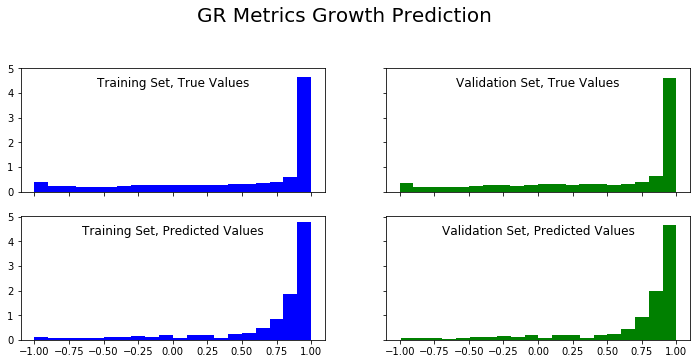

In [404]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2, nrows=2, sharey=True, sharex=True)

plt.suptitle('GR Metrics Growth Prediction', y=1.05, fontsize=20)
#plt.title('+1 = No Effect, 0 = Cytostatic response, -1 = Cell Death', y=1.0, fontsize=10)

axes[0][0].hist(y['train'], bins=20, density=True, color='b')
axes[0][0].set_title('Training Set, True Values', y=.8)

axes[0][1].hist(y['dev'], bins=20, density=True, color='g')
axes[0][1].set_title('Validation Set, True Values', y=.8)

axes[1][0].hist((norm.cdf(p_train)-.5)*2, bins=20, density=True, color='b')
axes[1][0].set_title('Training Set, Predicted Values', y=.8)

axes[1][1].hist((norm.cdf(p_dev)-.5)*2, bins=20, density=True, color='g')
axes[1][1].set_title('Validation Set, Predicted Values', y=.8)

plt.show()